# Fermi-Hubbard-1D

In [46]:
import os
import json
import pandas as pd

# Directory containing the JSON files
data_folder = "__data"

# Initialize lists to store data
data_fh = []
data_fh_noiseless = []

# Function to extract parts from filename
def extract_parts(filename):
    parts = filename.split('_')
    if len(parts) >= 10:
        method = parts[3]
        pbc_val = parts[5]
        U = parts[7]
        enc = parts[9].split('.')[0]
        return method, pbc_val, U, enc
    else:
        return None, None, None, None

# Traverse the directory and read each JSON file
for filename in os.listdir(data_folder):
    if 'fh_' in filename and filename.endswith(".json"):
        file_path = os.path.join(data_folder, filename)
        with open(file_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {filename}: {e}")
                continue
            
            method, pbc_val, U, enc = extract_parts(filename)
            if not method or not pbc_val or not U or not enc:
                continue

            # Ensure U is numeric
            try:
                U = int(U)
            except ValueError:
                continue

            # Extract avg_fidelities and avg_depths
            try:
                metrics = json_data["Benchmark Results - Hamiltonian Simulation - Qiskit"]["group_metrics"]
                avg_fidelities = metrics["avg_fidelities"]
                avg_depths = metrics["avg_depths"]
                groups = metrics["groups"]
                
                # Store the data in the appropriate list
                for group, fidelity, depth in zip(groups, avg_fidelities, avg_depths):
                    data_entry = {
                        "method": method,
                        "pbc_val": pbc_val,
                        "U": U,
                        "enc": enc,
                        "group": group,
                        "avg_fidelity": fidelity,
                        "avg_depth": depth
                    }
                    if 'noiseless' in filename:
                        data_fh_noiseless.append(data_entry)
                    else:
                        data_fh.append(data_entry)
            except KeyError as e:
                continue

# Convert the lists to DataFrames
df_fh = pd.DataFrame(data_fh)
df_fh_noiseless = pd.DataFrame(data_fh_noiseless)

# Save the DataFrames to CSV files for easier plotting
df_fh.to_csv('__data/collected_fh_data.csv', index=False)
df_fh_noiseless.to_csv('__data/collected_fh_data_noiseless.csv', index=False)

# Display the DataFrames
print("Regular FH Data DataFrame")
print(df_fh)
print("\nNoiseless FH Data DataFrame")
print(df_fh_noiseless)


Regular FH Data DataFrame
    method pbc_val   U enc group  avg_fidelity  avg_depth
0        2  nonpbc   8  bk     4         0.703      110.0
1        2  nonpbc   8  bk     6         0.501      226.0
2        2  nonpbc   8  bk     8         0.486      298.0
3        2  nonpbc   8  bk    10         0.265      473.0
4        3  nonpbc  12  bk     4         0.498      165.0
..     ...     ...  ..  ..   ...           ...        ...
427      3     pbc   8  bk    10         0.014      930.0
428      2     pbc   8  jw     4         0.799       25.0
429      2     pbc   8  jw     6         0.480      127.0
430      2     pbc   8  jw     8         0.312      147.0
431      2     pbc   8  jw    10         0.272      173.0

[432 rows x 7 columns]

Noiseless FH Data DataFrame
    method pbc_val   U     enc group  avg_fidelity  avg_depth
0        2     pbc  12      bk     4         1.000      110.0
1        2     pbc  12      bk     6         0.689      370.0
2        2     pbc  12      bk     8   

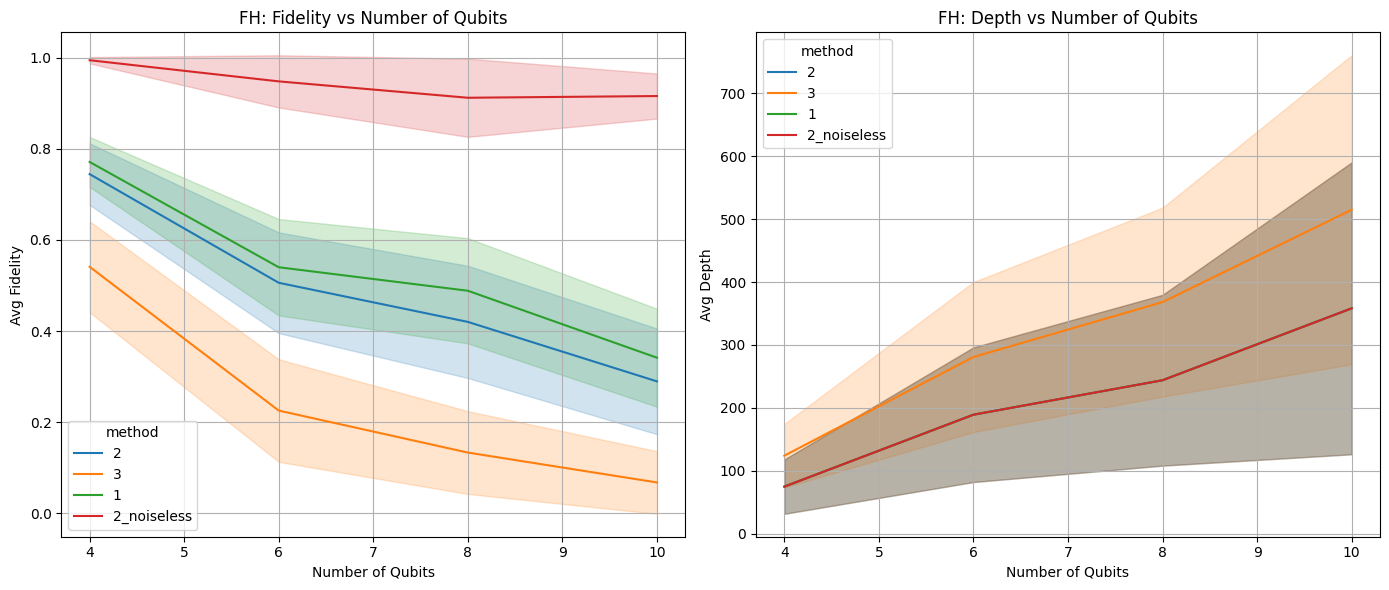

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)
df_combined['method'] = df_combined['method'].astype(str)

# Plot fidelity vs number of qubits
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=df_combined, x='group', y='avg_fidelity', hue='method', estimator='mean', errorbar='sd')
plt.title('FH: Fidelity vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Fidelity')
plt.grid(True)

# Plot depth vs number of qubits
plt.subplot(1, 2, 2)
sns.lineplot(data=df_combined, x='group', y='avg_depth', hue='method', estimator='mean', errorbar='sd')
plt.title('FH: Depth vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Depth')
plt.grid(True)

plt.tight_layout()
plt.show()


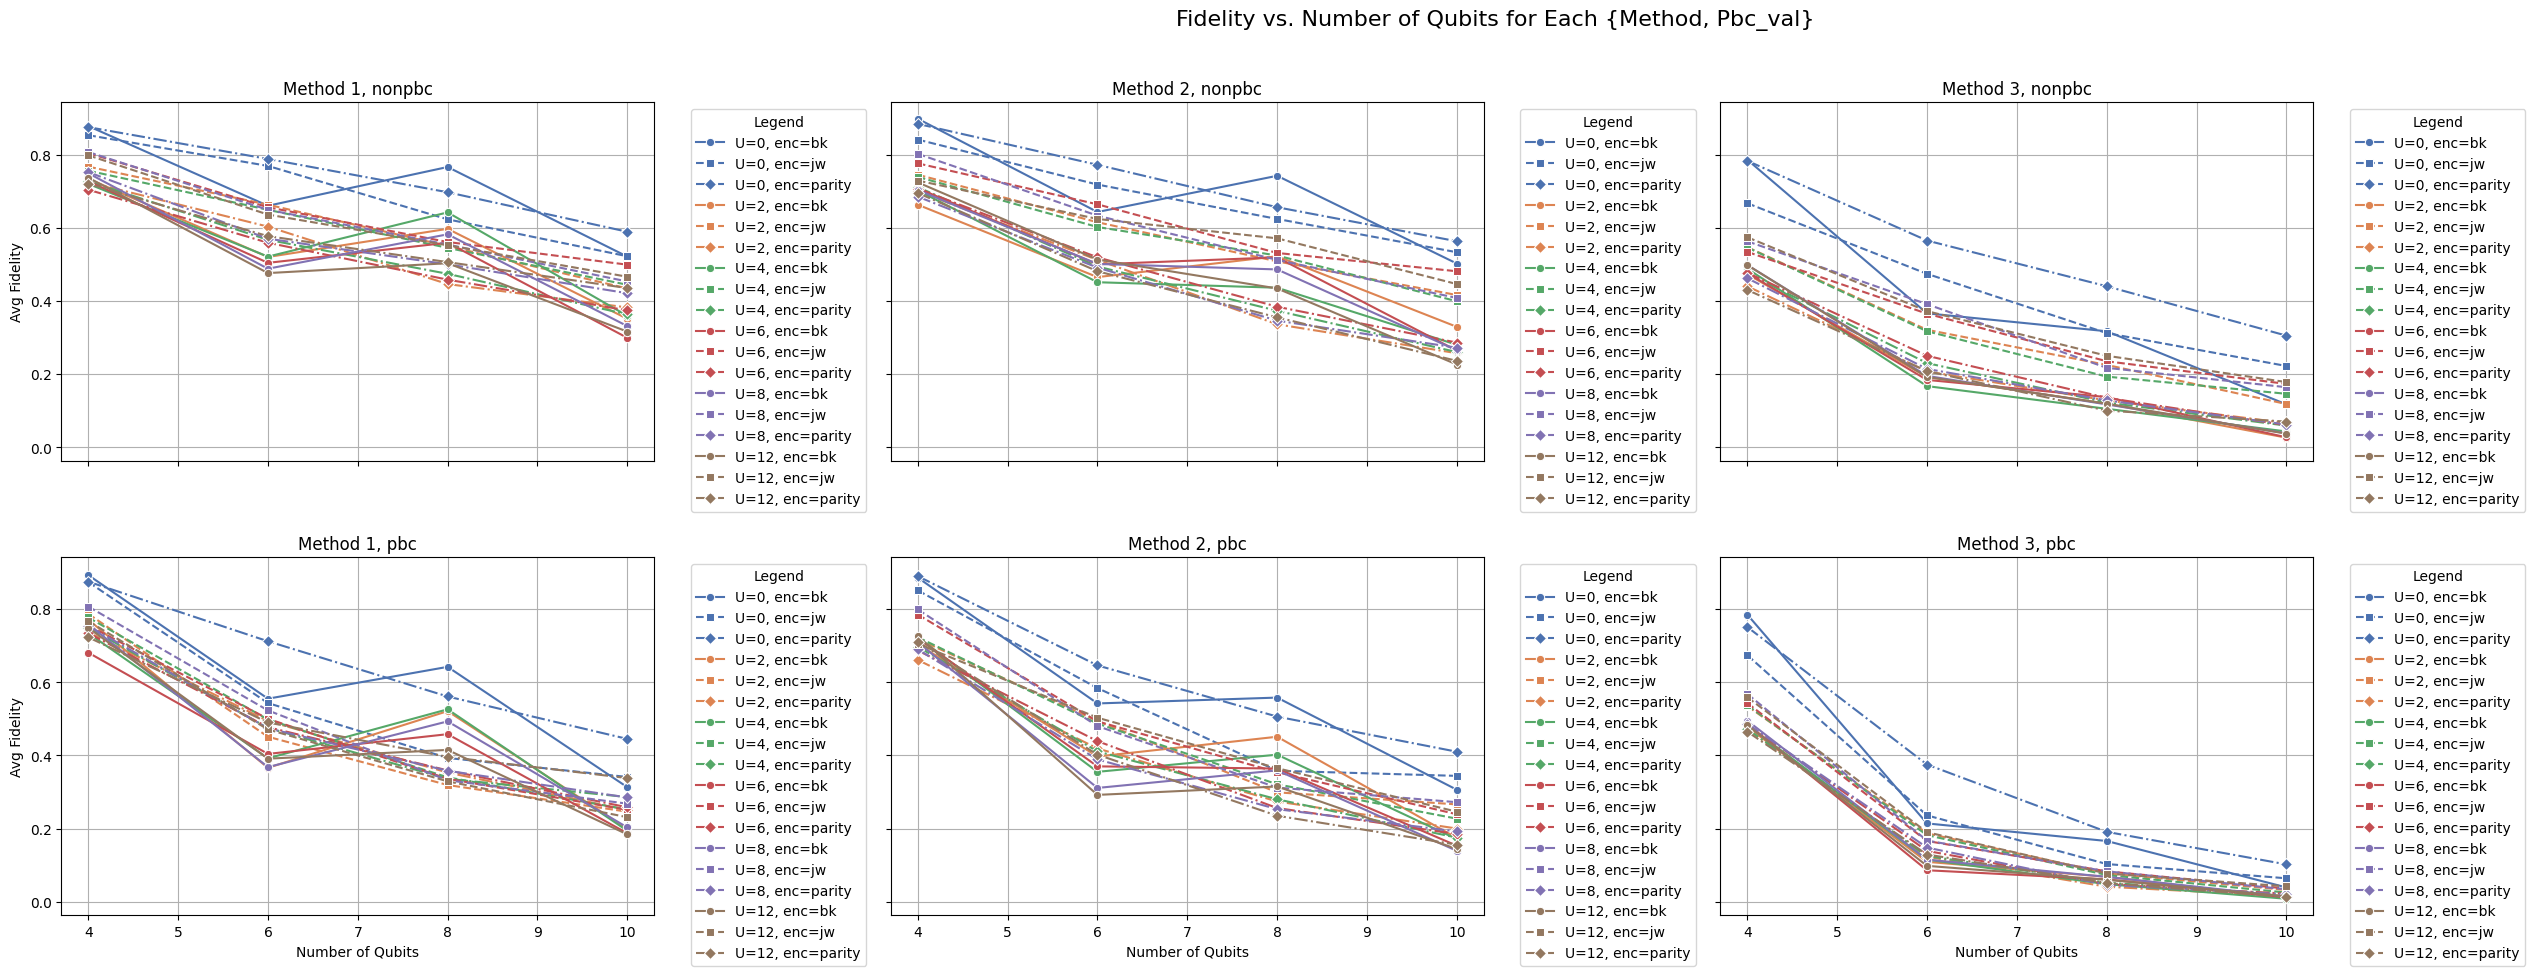

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('__data/collected_fh_data.csv')

# Ensure U and group are treated as integers
df['U'] = df['U'].astype(int)
df['group'] = df['group'].astype(int)

# Create heatmaps for each method and pbc_val
methods = sorted(df['method'].unique())  # Ensure methods are ordered
pbc_vals = df['pbc_val'].unique()
unique_us = sorted(df['U'].unique())
unique_encs = sorted(df['enc'].unique())
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H']  # Different shapes for different encodings
line_styles = ['-', '--', '-.', ':']  # Different line styles for different encodings

# Ensure there are enough markers and line styles
if len(unique_encs) > len(markers):
    markers = markers * (len(unique_encs) // len(markers) + 1)
if len(unique_encs) > len(line_styles):
    line_styles = line_styles * (len(unique_encs) // len(line_styles) + 1)

# Set up the figure for subplots
fig, axs = plt.subplots(len(pbc_vals), len(methods), figsize=(10 * len(methods), 5 * len(pbc_vals)), sharey=True, sharex=True)
fig.suptitle('Fidelity vs. Number of Qubits for Each {Method, Pbc_val}', fontsize=16)

for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        subset = df[(df['method'] == method) & (df['pbc_val'] == pbc_val)]
        
        ax = axs[i, j]
        
        for U, color in zip(unique_us, sns.color_palette("deep", len(unique_us))):
            for k, (enc, marker, line_style) in enumerate(zip(unique_encs, markers, line_styles)):
                enc_subset = subset[(subset['U'] == U) & (subset['enc'] == enc)]
                if not enc_subset.empty:
                    sns.lineplot(
                        x='group', y='avg_fidelity', data=enc_subset, 
                        marker=marker, linestyle=line_style, color=color, ax=ax, label=f'U={U}, enc={enc}'
                    )

        ax.set_title(f'Method {method}, {pbc_val}')
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Fidelity')
        ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()


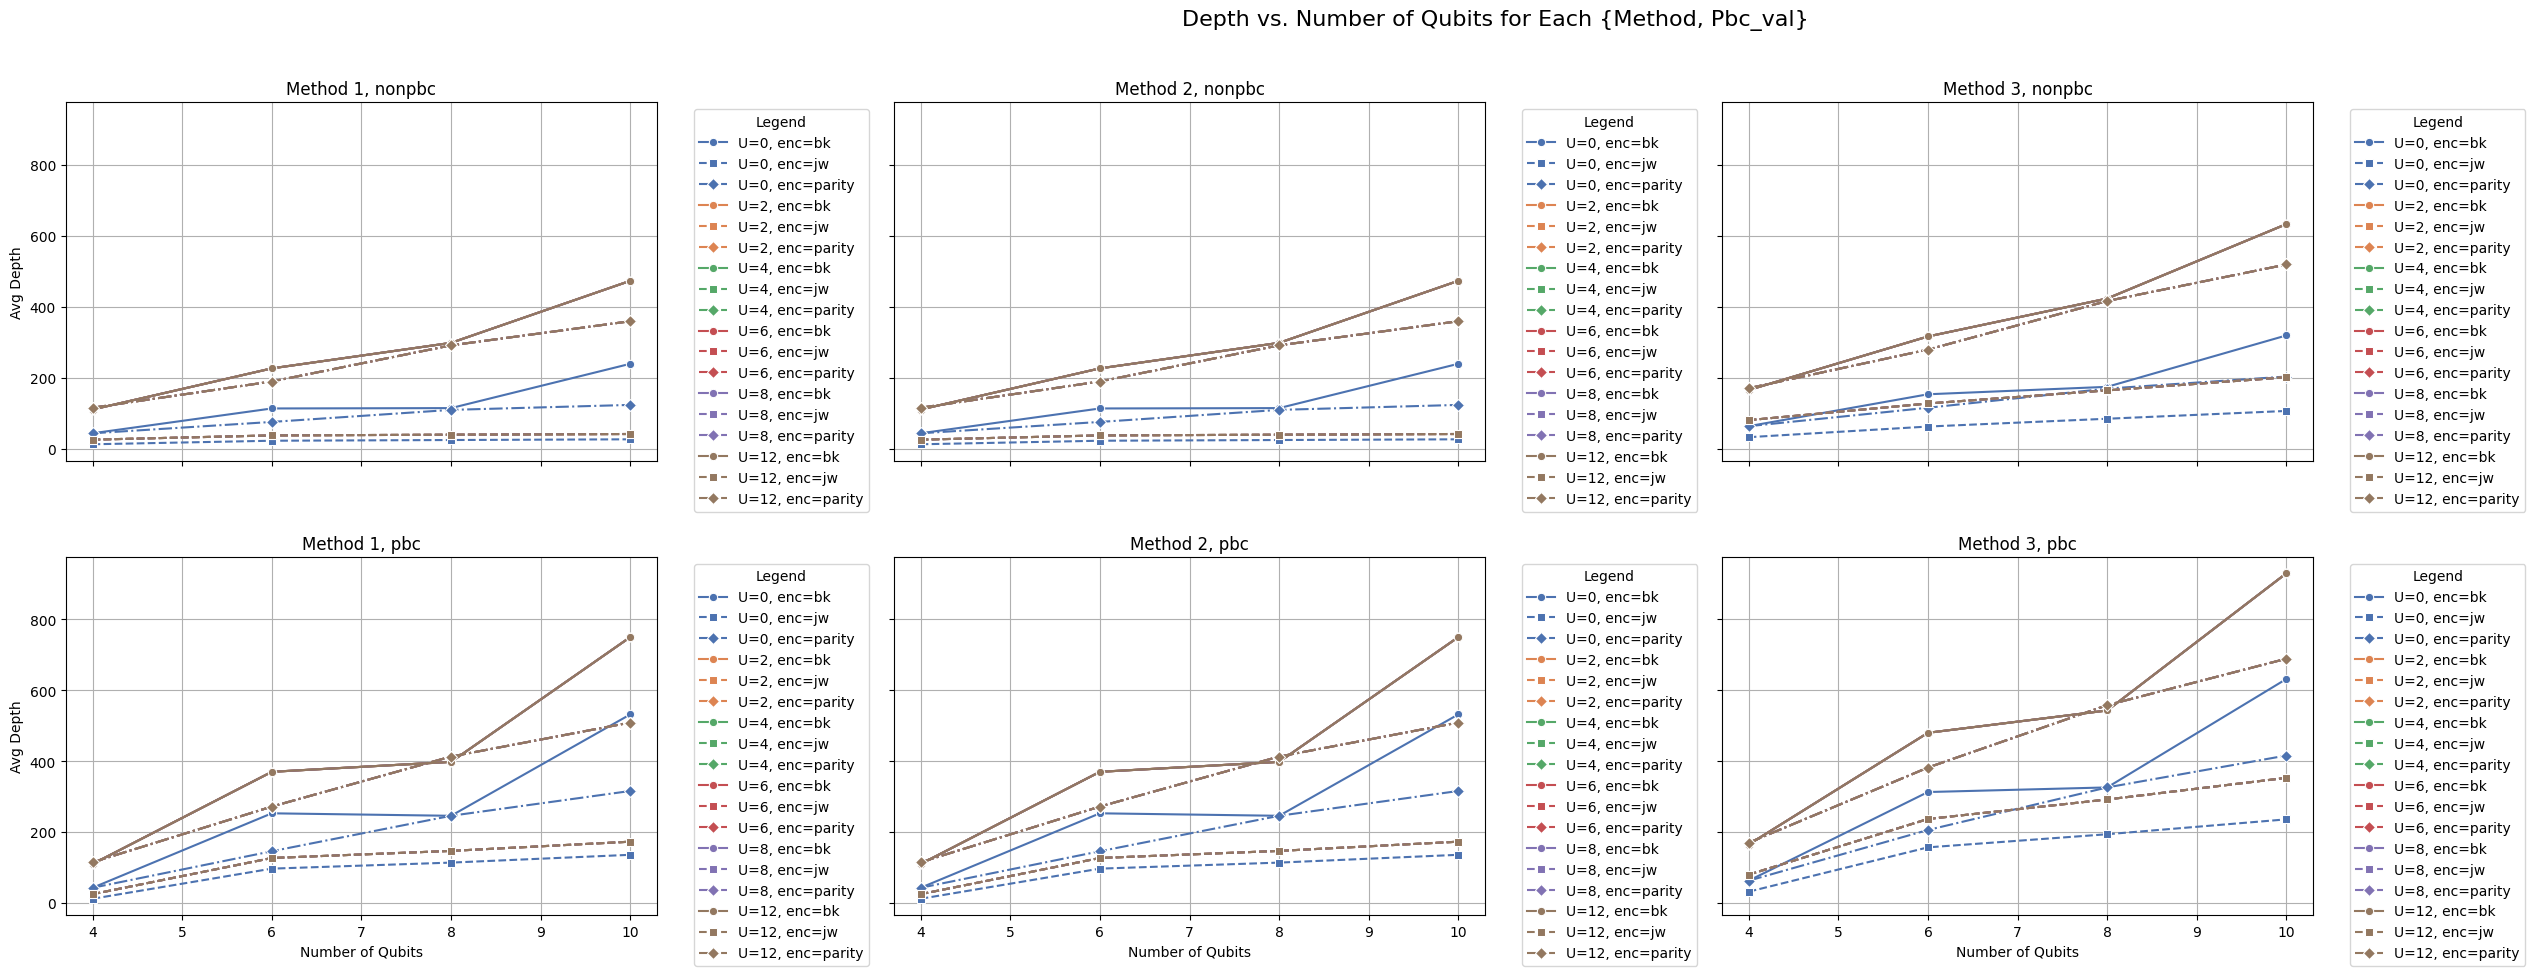

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('__data/collected_fh_data.csv')

# Ensure U and group are treated as integers
df['U'] = df['U'].astype(int)
df['group'] = df['group'].astype(int)

# Create heatmaps for each method and pbc_val
methods = sorted(df['method'].unique())  # Ensure methods are ordered
pbc_vals = df['pbc_val'].unique()
unique_us = sorted(df['U'].unique())
unique_encs = sorted(df['enc'].unique())
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H']  # Different shapes for different encodings
line_styles = ['-', '--', '-.', ':']  # Different line styles for different encodings

# Ensure there are enough markers and line styles
if len(unique_encs) > len(markers):
    markers = markers * (len(unique_encs) // len(markers) + 1)
if len(unique_encs) > len(line_styles):
    line_styles = line_styles * (len(unique_encs) // len(line_styles) + 1)

# Set up the figure for subplots
fig, axs = plt.subplots(len(pbc_vals), len(methods), figsize=(10 * len(methods), 5 * len(pbc_vals)), sharey=True, sharex=True)
fig.suptitle('Depth vs. Number of Qubits for Each {Method, Pbc_val}', fontsize=16)

for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        subset = df[(df['method'] == method) & (df['pbc_val'] == pbc_val)]
        
        ax = axs[i, j]
        
        for U, color in zip(unique_us, sns.color_palette("deep", len(unique_us))):
            for k, (enc, marker, line_style) in enumerate(zip(unique_encs, markers, line_styles)):
                enc_subset = subset[(subset['U'] == U) & (subset['enc'] == enc)]
                if not enc_subset.empty:
                    sns.lineplot(
                        x='group', y='avg_depth', data=enc_subset, 
                        marker=marker, linestyle=line_style, color=color, ax=ax, label=f'U={U}, enc={enc}'
                    )

        ax.set_title(f'Method {method}, {pbc_val}')
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Depth')
        ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()


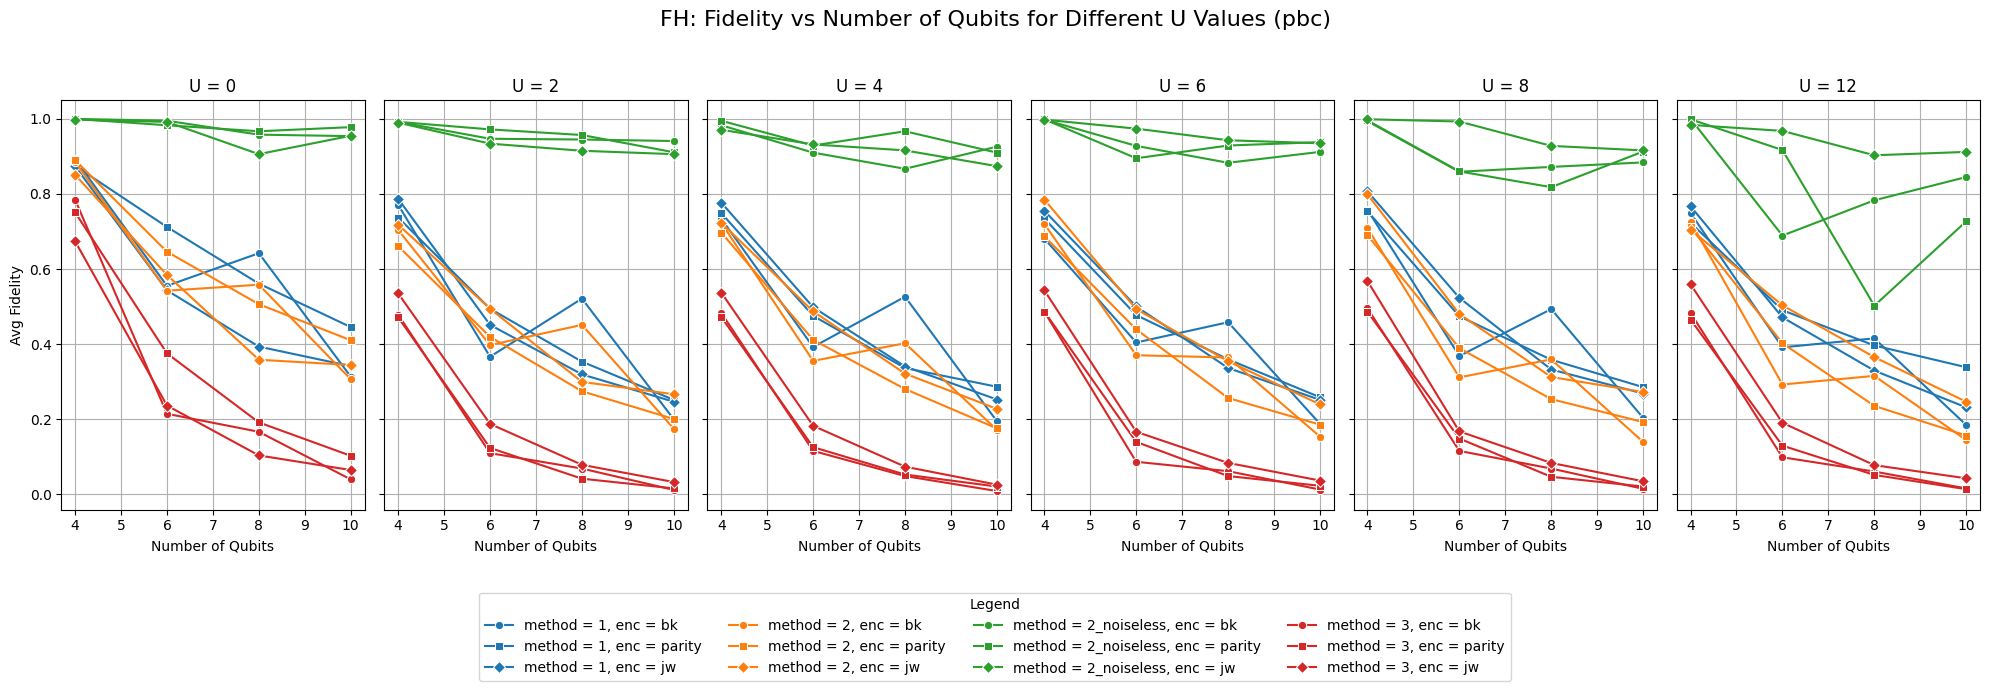

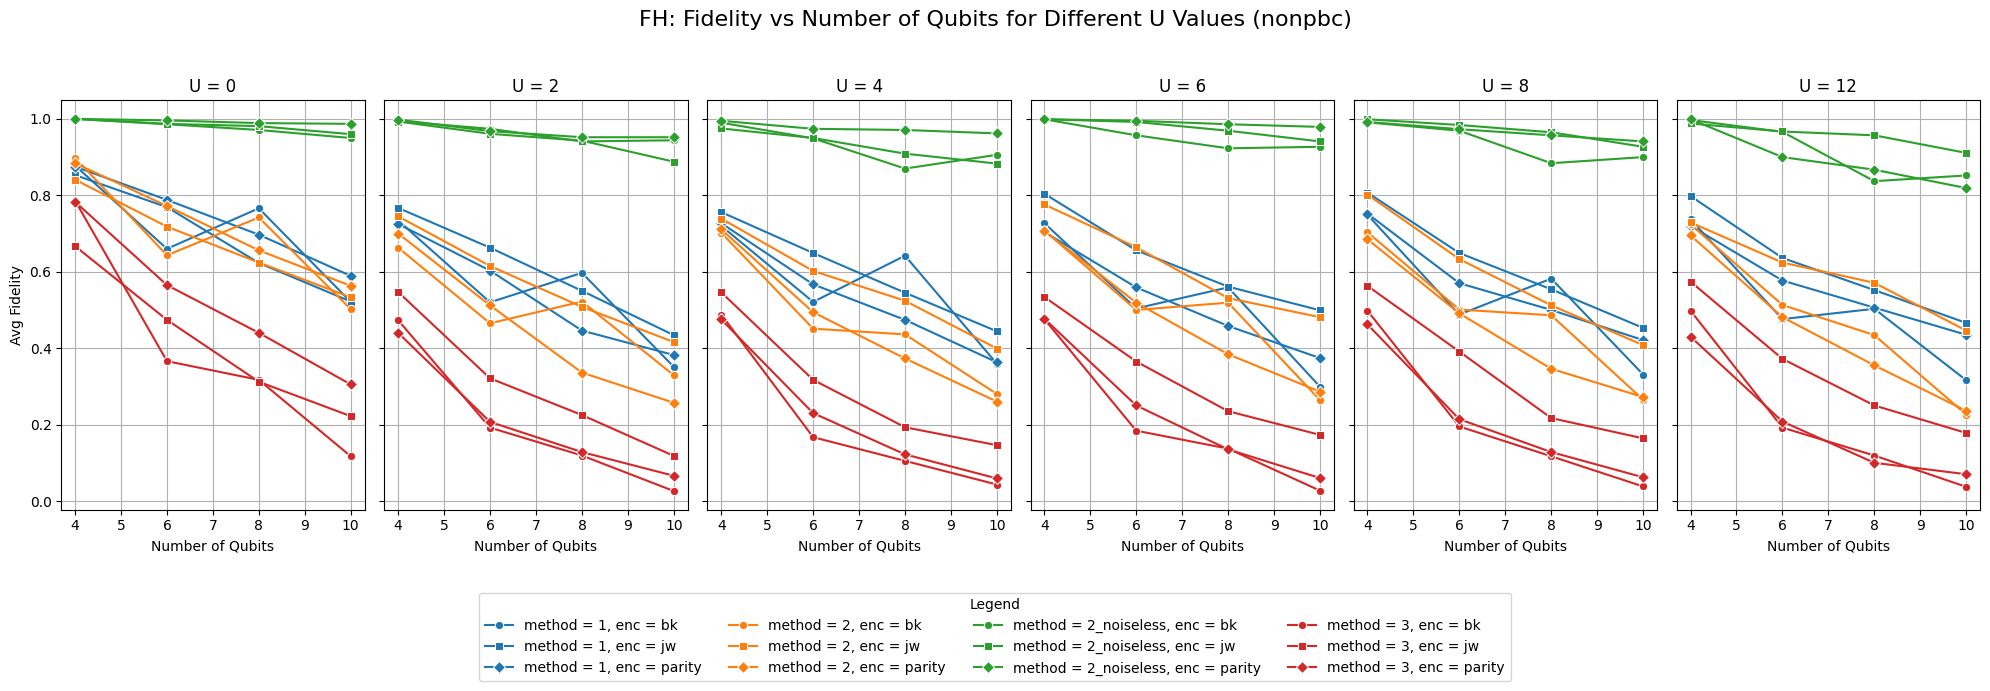

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Define methods, colors, and markers
methods = ['1', '2', '2_noiseless', '3']
colors = sns.color_palette("tab10", len(methods))
markers = ['o', 's', 'D']

# Ensure 'group' and 'U' are treated as integers
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Unique U values
U_values = sorted(df_combined['U'].unique())
pbc_values = ['pbc', 'nonpbc']

# Function to create plots for a given pbc_val
def plot_for_pbc(pbc_val):
    subset_df = df_combined[df_combined['pbc_val'] == pbc_val]

    # Set up the figure for subplots
    fig, axs = plt.subplots(1, len(U_values), figsize=(20, 6), sharey=True)
    fig.suptitle(f'FH: Fidelity vs Number of Qubits for Different U Values ({pbc_val})', fontsize=16)

    for ax, U in zip(axs.flat, U_values):
        for method, color in zip(methods, colors):
            for enc, marker in zip(subset_df['enc'].unique(), markers):
                subset = subset_df[(subset_df['U'] == U) & (subset_df['method'] == method) & (subset_df['enc'] == enc)]
                if not subset.empty:
                    label = f"method = {method}, enc = {enc}"
                    sns.lineplot(data=subset, x='group', y='avg_fidelity', ax=ax, label=label, color=color, marker=marker, errorbar=None)
        
        ax.set_title(f"U = {U}")
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Fidelity')
        ax.grid(True)
        ax.legend_.remove()  # Remove the legend from the subplot

    # Create a single legend for all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), title='Legend', ncol=4)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Plot for PBC and non-PBC values
for pbc_val in pbc_values:
    plot_for_pbc(pbc_val)


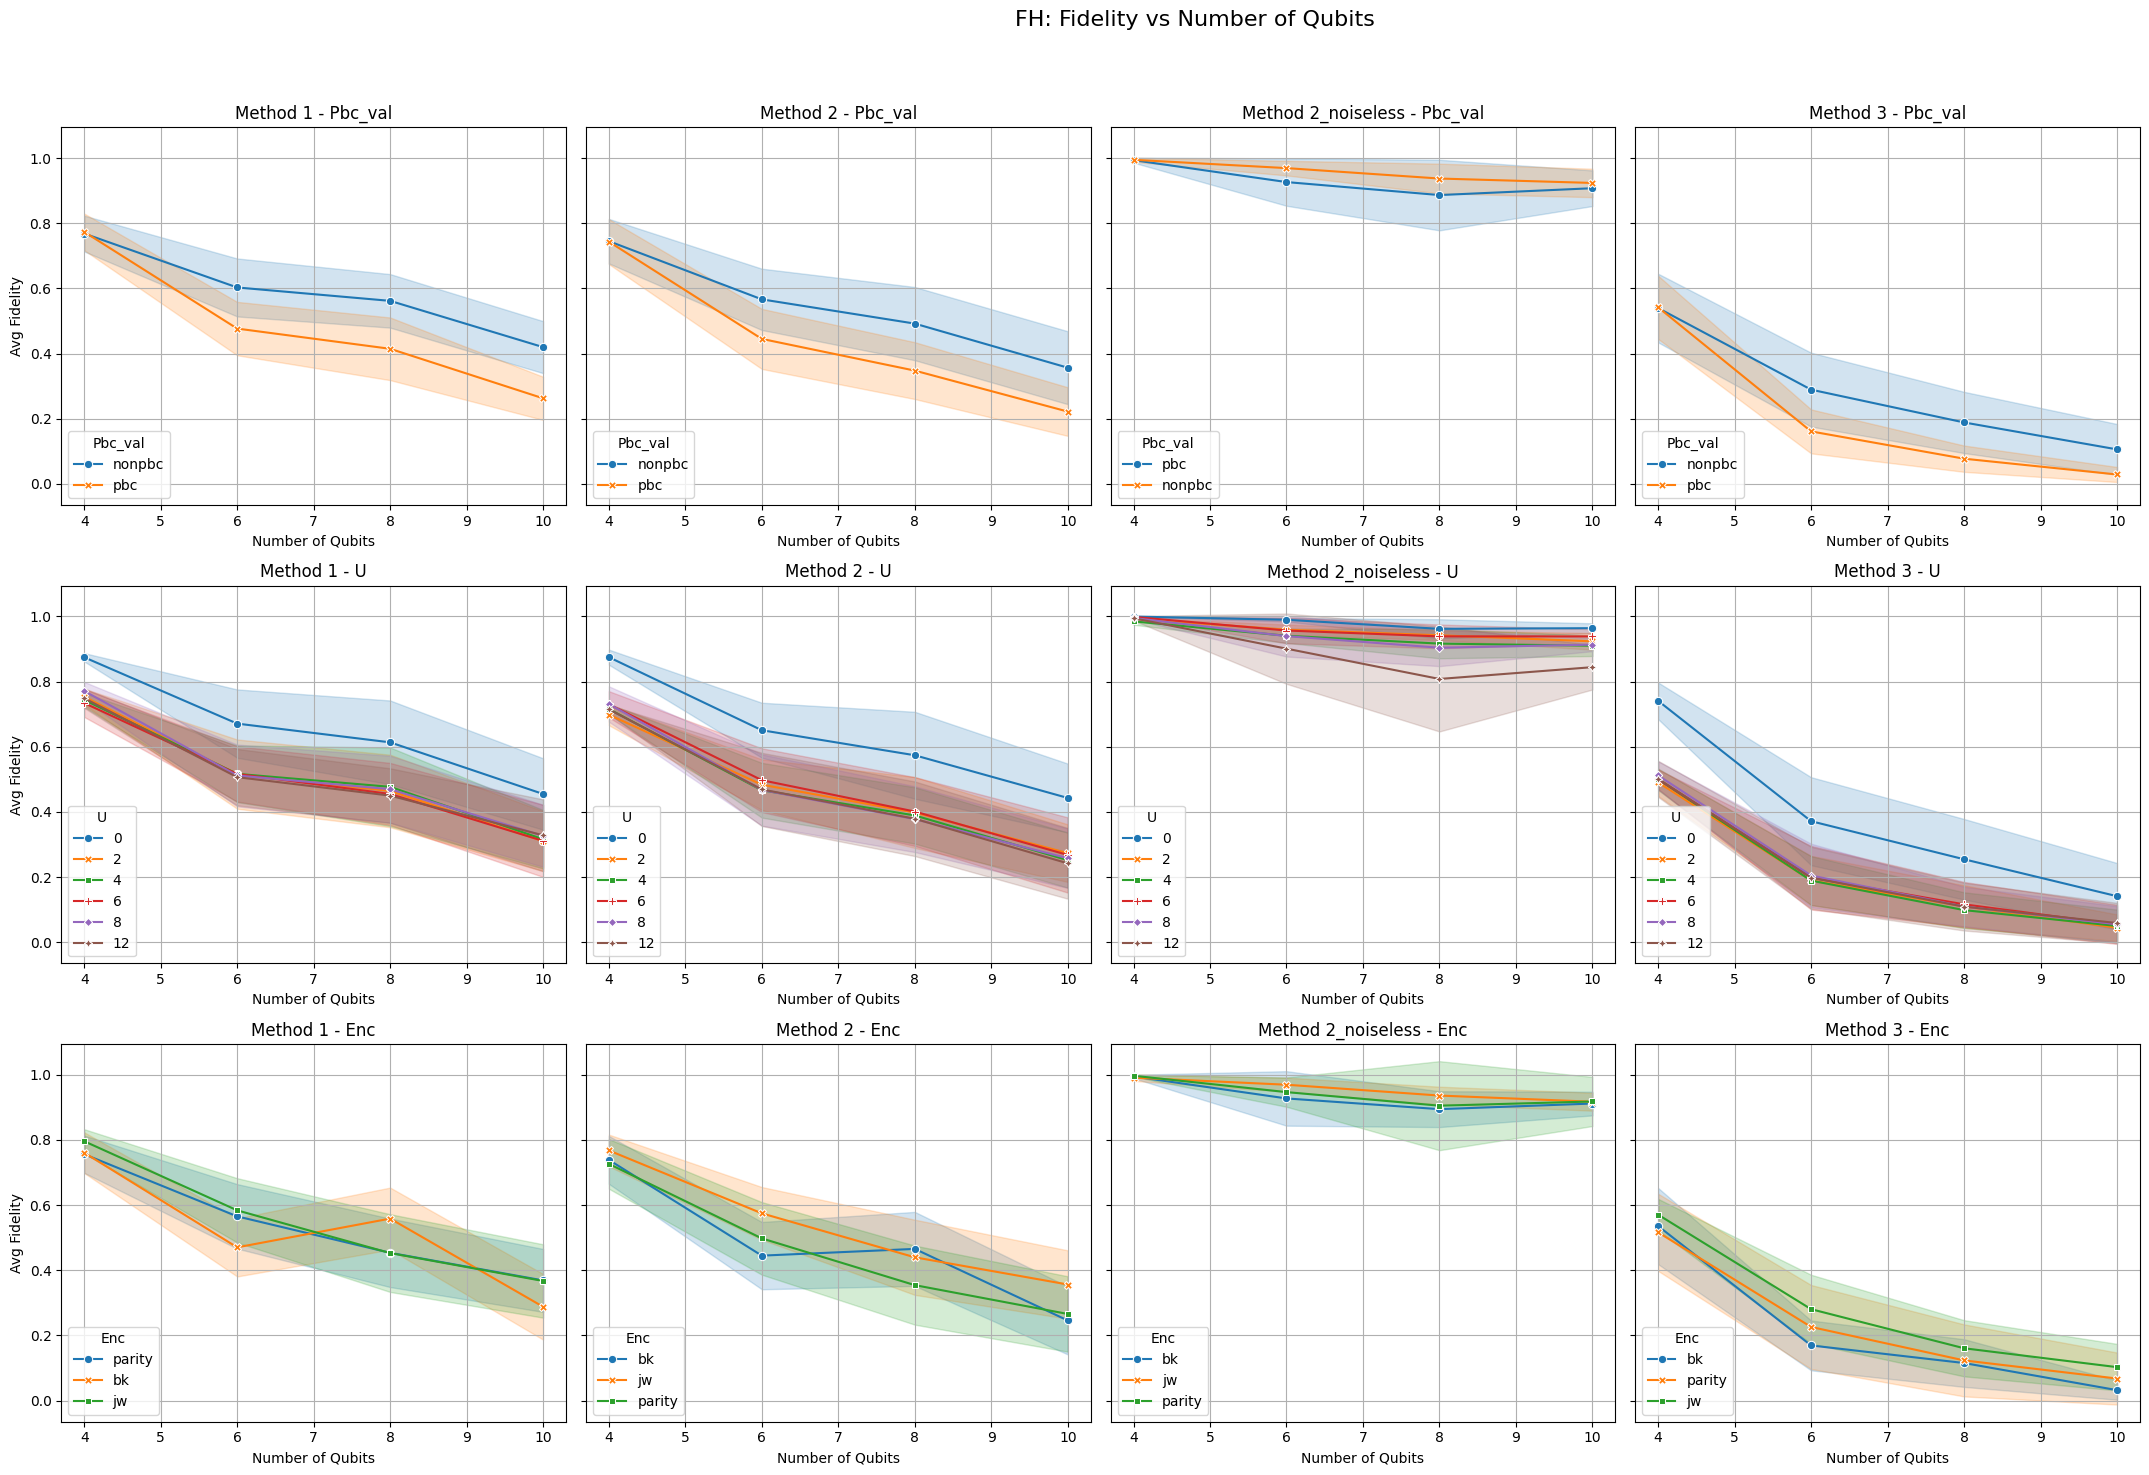

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers where applicable
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Define methods and rows
methods = ['1', '2', '2_noiseless', '3']
rows = ['pbc_val', 'U', 'enc']
cols = methods

# Set up the figure for subplots
fig, axs = plt.subplots(3, 4, figsize=(24, 15), sharey=True)
fig.suptitle('FH: Fidelity vs Number of Qubits', fontsize=16)

# Plotting function
def plot_subplot(ax, df, row, col, hue):
    palette = sns.color_palette("tab10", len(df[hue].unique()))
    sns.lineplot(
        data=df[df['method'] == col], x='group', y='avg_fidelity', hue=hue, 
        style=hue, ax=ax, markers=True, dashes=False, palette=palette, errorbar='sd'
    )
    ax.set_title(f"Method {col} - {row.capitalize()}")
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Avg Fidelity')
    ax.grid(True)
    ax.legend(title=hue.capitalize(), loc='lower left')

# Generate plots
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        plot_subplot(axs[i, j], df_combined, row, col, row)

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


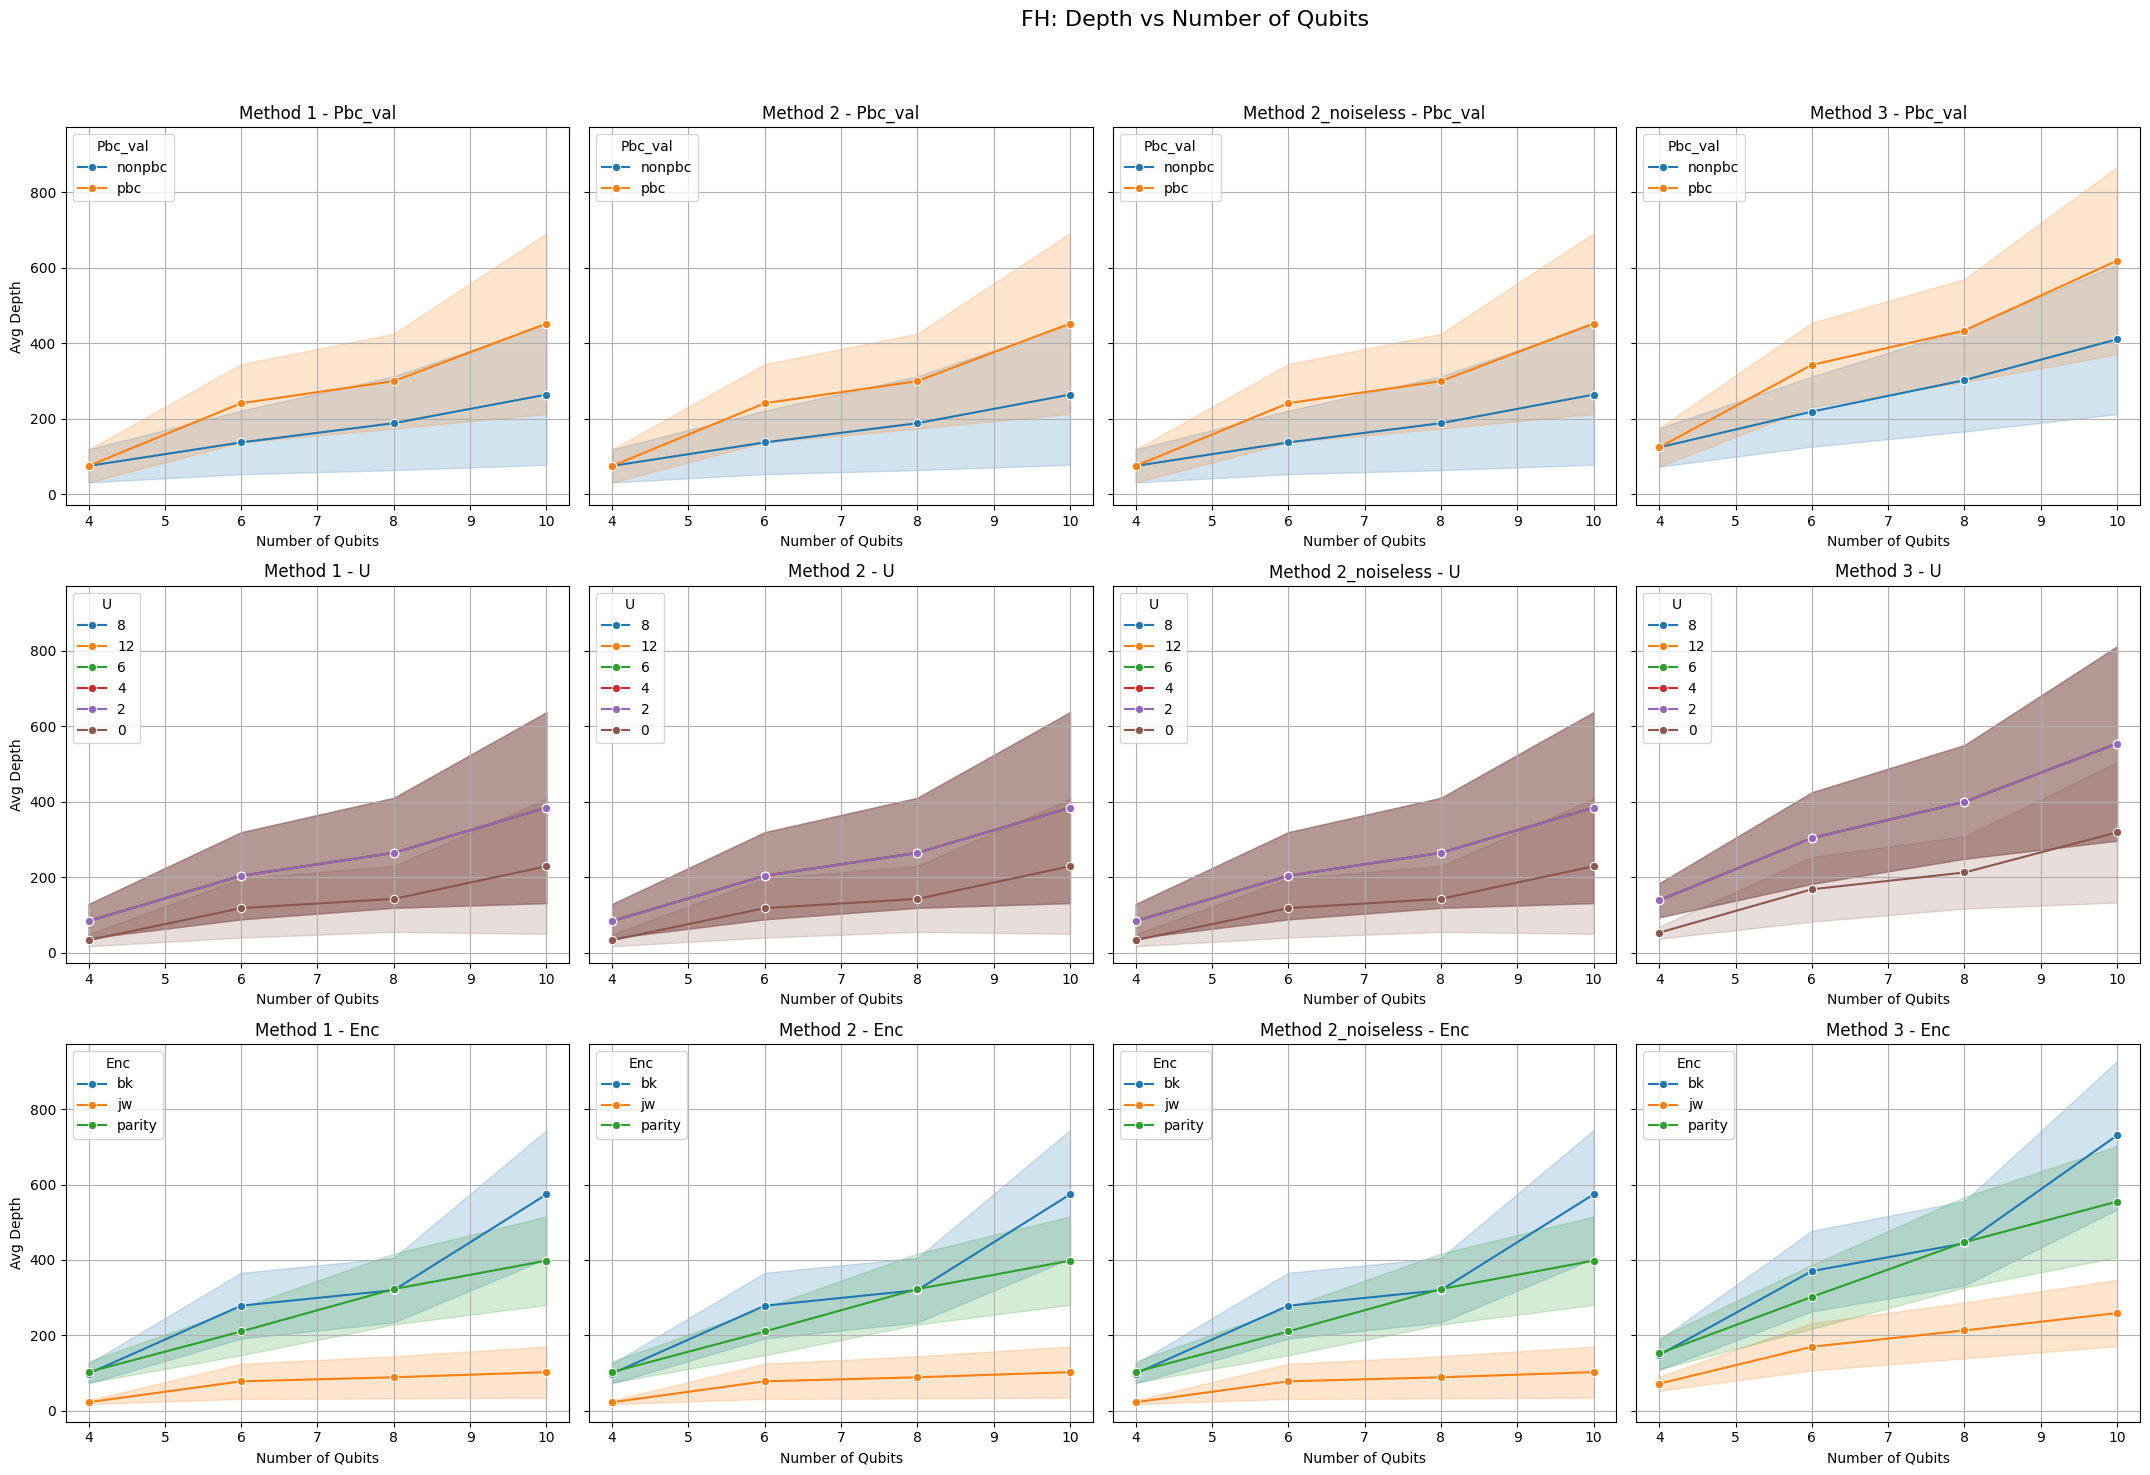

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers where applicable
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Define methods and rows
methods = ['1', '2', '2_noiseless', '3']
rows = ['pbc_val', 'U', 'enc']
cols = methods

# Set up the figure for subplots
fig, axs = plt.subplots(3, 4, figsize=(24, 15), sharey=True)
fig.suptitle('FH: Depth vs Number of Qubits', fontsize=16)

# Plotting function
def plot_subplot(ax, df, row, col, hue):
    unique_values = df[hue].unique()
    palette = sns.color_palette("tab10", len(unique_values))
    
    for color, hue_value in zip(palette, unique_values):
        subset = df[(df['method'] == col) & (df[row] == hue_value)]
        if not subset.empty:
            sns.lineplot(
                data=subset, x='group', y='avg_depth', label=hue_value,
                ax=ax, color=color, marker='o', errorbar='sd'
            )
            ax.set_title(f"Method {col} - {row.capitalize()}")
            ax.set_xlabel('Number of Qubits')
            ax.set_ylabel('Avg Depth')
            ax.grid(True)
            ax.legend(title=hue.capitalize(), loc='upper left')

# Generate plots
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        plot_subplot(axs[i, j], df_combined, row, col, row)

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


# Bose-Hubbard-1D

In [52]:
import os
import json
import pandas as pd

# Directory containing the JSON files
data_folder = "__data"

# Initialize lists to store data
bh_data = []
bh_data_noiseless = []

# Function to extract parts from filename
def extract_parts(filename):
    parts = filename.split('_')
    if len(parts) >= 10:
        method = parts[3]
        pbc_val = parts[5]
        U = parts[7]
        enc = parts[9].split('.')[0]
        return method, pbc_val, U, enc
    else:
        return None, None, None, None

# Traverse the directory and read each JSON file
for filename in os.listdir(data_folder):
    if 'bh_' in filename and filename.endswith(".json"):
        file_path = os.path.join(data_folder, filename)
        with open(file_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {filename}: {e}")
                continue
            
            method, pbc_val, U, enc = extract_parts(filename)
            if not method or not pbc_val or not U or not enc:
                continue

            # Ensure U is numeric
            try:
                U = int(U)
            except ValueError:
                continue

            # Extract avg_fidelities and avg_depths
            try:
                metrics = json_data["Benchmark Results - Hamiltonian Simulation - Qiskit"]["group_metrics"]
                avg_fidelities = metrics["avg_fidelities"]
                avg_depths = metrics["avg_depths"]
                groups = metrics["groups"]
                
                # Store the data in the appropriate list
                for group, fidelity, depth in zip(groups, avg_fidelities, avg_depths):
                    data_entry = {
                        "method": method,
                        "pbc_val": pbc_val,
                        "U": U,
                        "enc": enc,
                        "group": group,
                        "avg_fidelity": fidelity,
                        "avg_depth": depth
                    }
                    if 'noiseless' in filename:
                        bh_data_noiseless.append(data_entry)
                    else:
                        bh_data.append(data_entry)
            except KeyError as e:
                continue

# Convert the lists to DataFrames
df_bh = pd.DataFrame(bh_data)
df_bh_noiseless = pd.DataFrame(bh_data_noiseless)

# Save the DataFrames to CSV files for easier plotting
df_bh.to_csv('__data/collected_bh_data.csv', index=False)
df_bh_noiseless.to_csv('__data/collected_bh_data_noiseless.csv', index=False)

# Display the DataFrames
print("Regular BH Data DataFrame")
print(df_bh)
print("\nNoiseless BH Data DataFrame")
print(df_bh_noiseless)


Regular BH Data DataFrame
    method pbc_val   U        enc group  avg_fidelity  avg_depth
0        3     pbc   2  stdbinary     4         0.021     1222.0
1        3     pbc   2  stdbinary     6         0.000     3657.0
2        3     pbc   2  stdbinary     8         0.000     4701.0
3        3     pbc   2  stdbinary    10         0.000     5921.0
4        2  nonpbc  10       gray     4         0.297      584.0
..     ...     ...  ..        ...   ...           ...        ...
235      2     pbc  10  stdbinary    10         0.000     5346.0
236      1     pbc   2       gray     4         0.334      584.0
237      1     pbc   2       gray     6         0.003     1710.0
238      1     pbc   2       gray     8         0.000     2076.0
239      1     pbc   2       gray    10         0.000     2656.0

[240 rows x 7 columns]

Noiseless BH Data DataFrame
   method pbc_val   U        enc group  avg_fidelity  avg_depth
0       2  nonpbc   2  stdbinary     4         0.941     1107.0
1       2  no

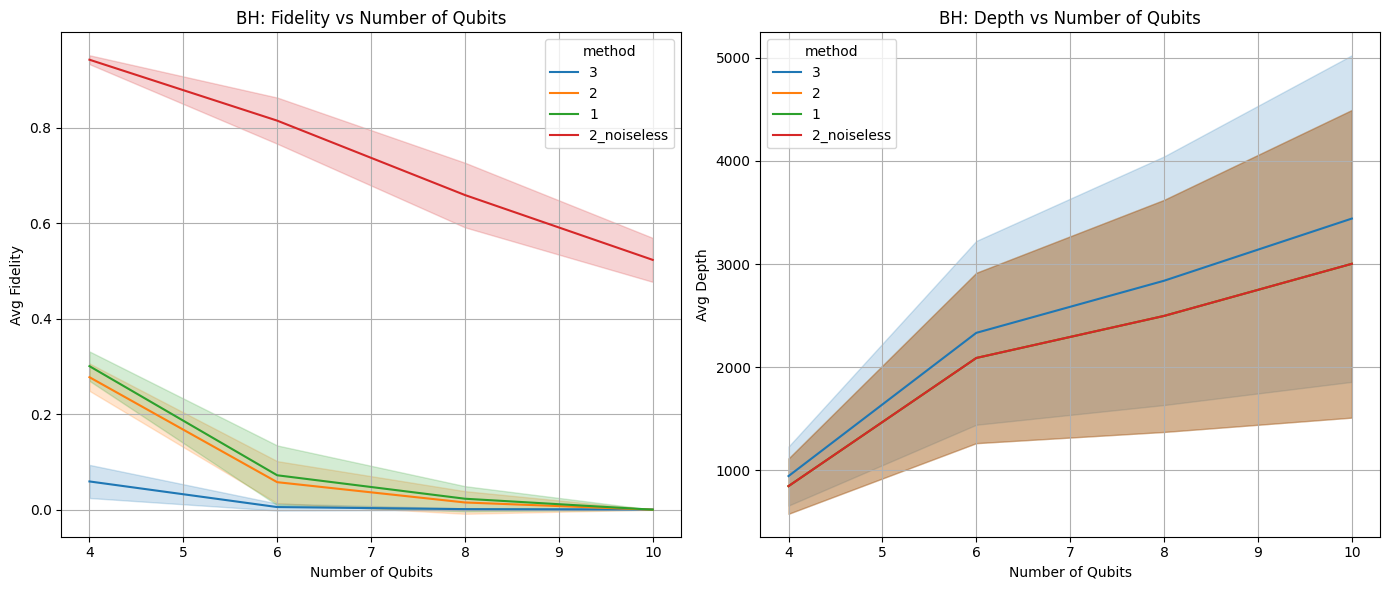

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_bh = pd.read_csv('__data/collected_bh_data.csv')
df_bh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_bh_noiseless['method'] = '2_noiseless'
df_bh['method'] = df_bh['method'].astype(str)
df_combined = pd.concat([df_bh, df_bh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)
df_combined['method'] = df_combined['method'].astype(str)

# Plot fidelity vs number of qubits
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=df_combined, x='group', y='avg_fidelity', hue='method', estimator='mean', errorbar='sd')
plt.title('BH: Fidelity vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Fidelity')
plt.grid(True)

# Plot depth vs number of qubits
plt.subplot(1, 2, 2)
sns.lineplot(data=df_combined, x='group', y='avg_depth', hue='method', estimator='mean', errorbar='sd')
plt.title('BH: Depth vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Depth')
plt.grid(True)

plt.tight_layout()
plt.show()


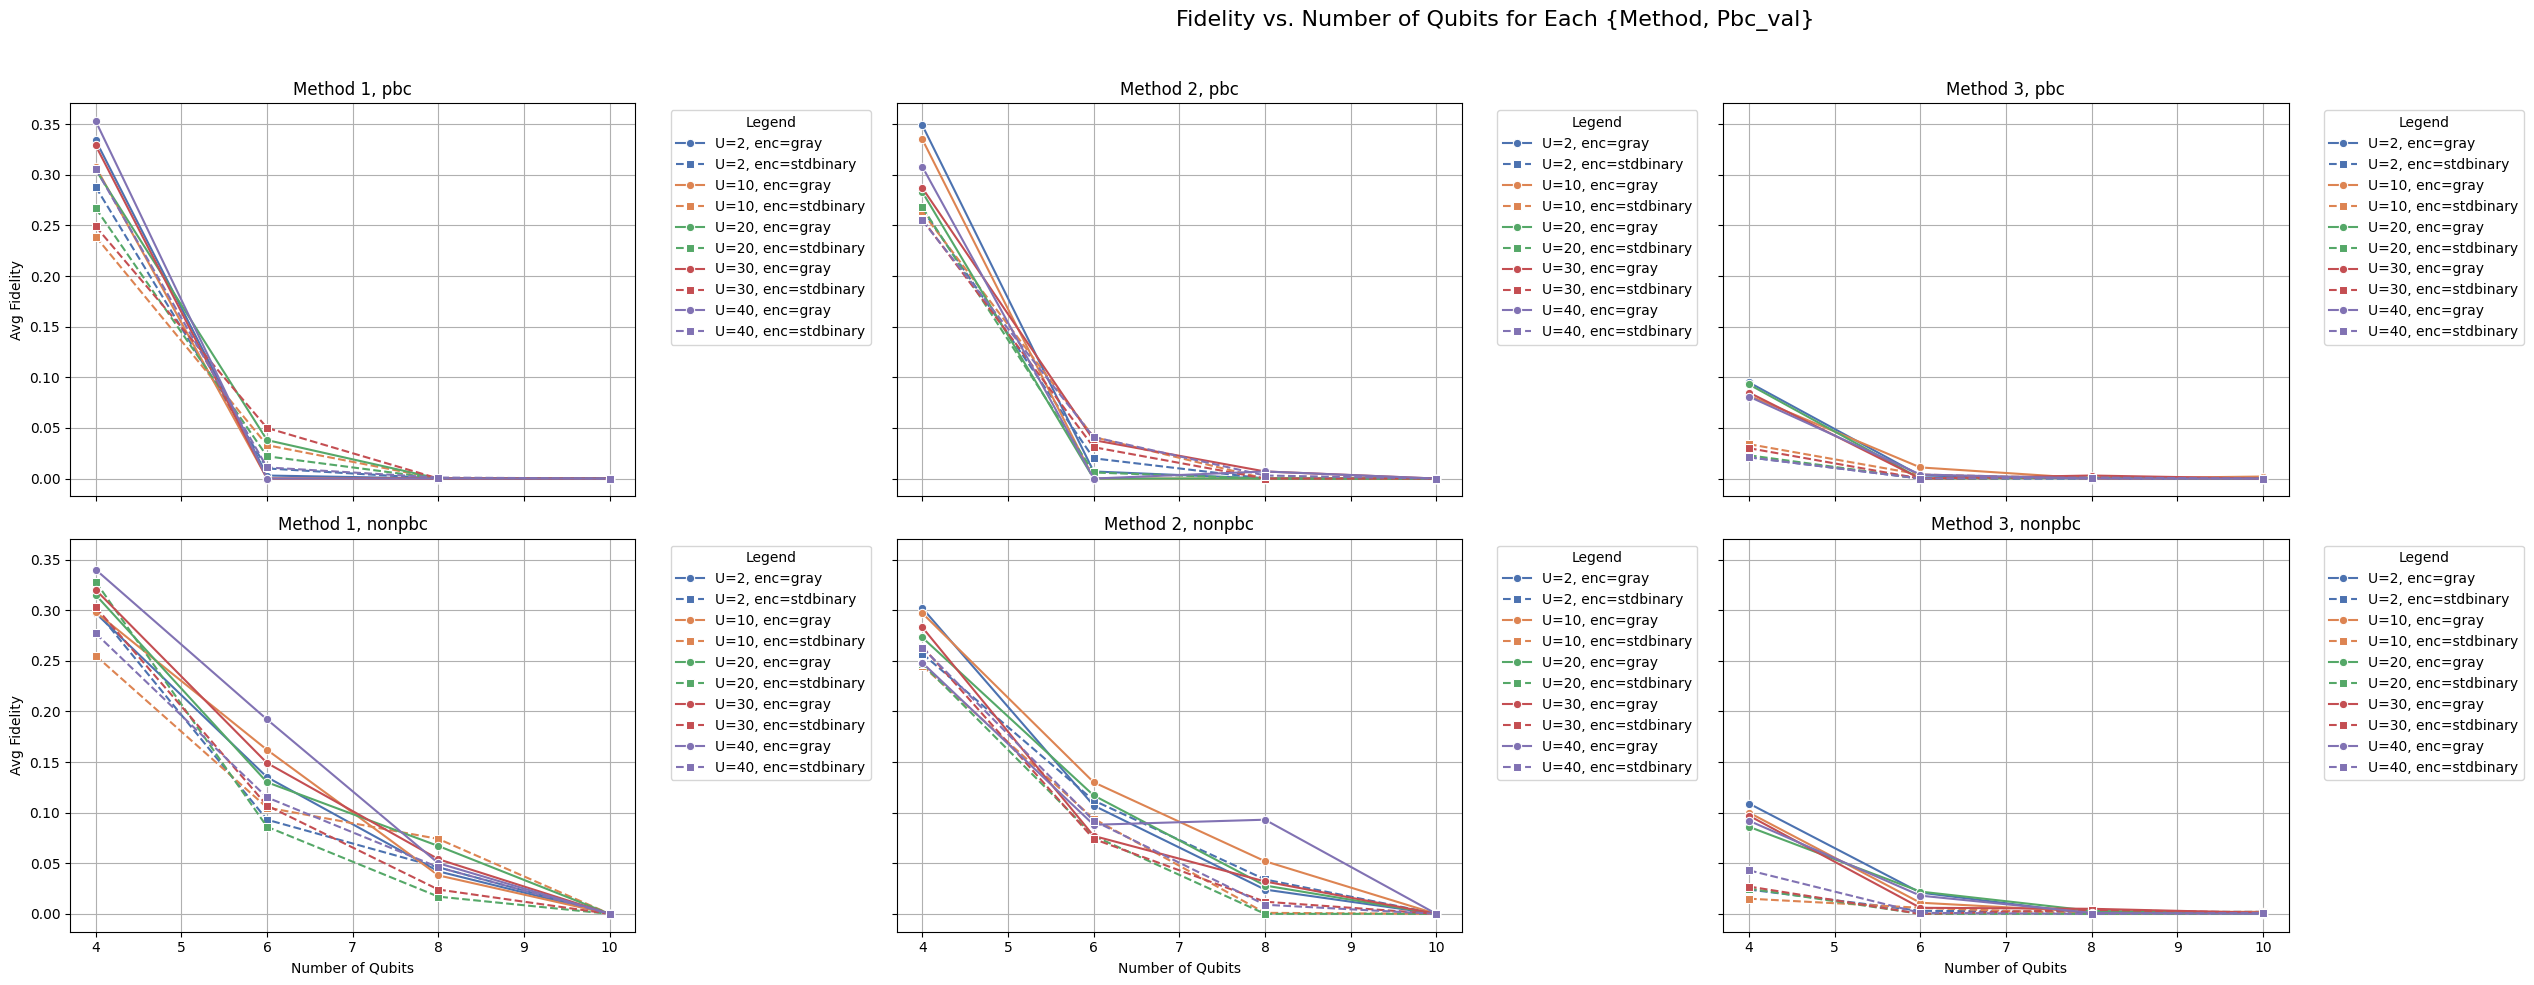

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('__data/collected_bh_data.csv')

# Ensure U and group are treated as integers
df['U'] = df['U'].astype(int)
df['group'] = df['group'].astype(int)

# Create heatmaps for each method and pbc_val
methods = sorted(df['method'].unique())  # Ensure methods are ordered
pbc_vals = df['pbc_val'].unique()
unique_us = sorted(df['U'].unique())
unique_encs = sorted(df['enc'].unique())
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H']  # Different shapes for different encodings
line_styles = ['-', '--', '-.', ':']  # Different line styles for different encodings

# Ensure there are enough markers and line styles
if len(unique_encs) > len(markers):
    markers = markers * (len(unique_encs) // len(markers) + 1)
if len(unique_encs) > len(line_styles):
    line_styles = line_styles * (len(unique_encs) // len(line_styles) + 1)

# Set up the figure for subplots
fig, axs = plt.subplots(len(pbc_vals), len(methods), figsize=(10 * len(methods), 5 * len(pbc_vals)), sharey=True, sharex=True)
fig.suptitle('Fidelity vs. Number of Qubits for Each {Method, Pbc_val}', fontsize=16)

for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        subset = df[(df['method'] == method) & (df['pbc_val'] == pbc_val)]
        
        ax = axs[i, j]
        
        for U, color in zip(unique_us, sns.color_palette("deep", len(unique_us))):
            for k, (enc, marker, line_style) in enumerate(zip(unique_encs, markers, line_styles)):
                enc_subset = subset[(subset['U'] == U) & (subset['enc'] == enc)]
                if not enc_subset.empty:
                    sns.lineplot(
                        x='group', y='avg_fidelity', data=enc_subset, 
                        marker=marker, linestyle=line_style, color=color, ax=ax, label=f'U={U}, enc={enc}'
                    )

        ax.set_title(f'Method {method}, {pbc_val}')
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Fidelity')
        ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()


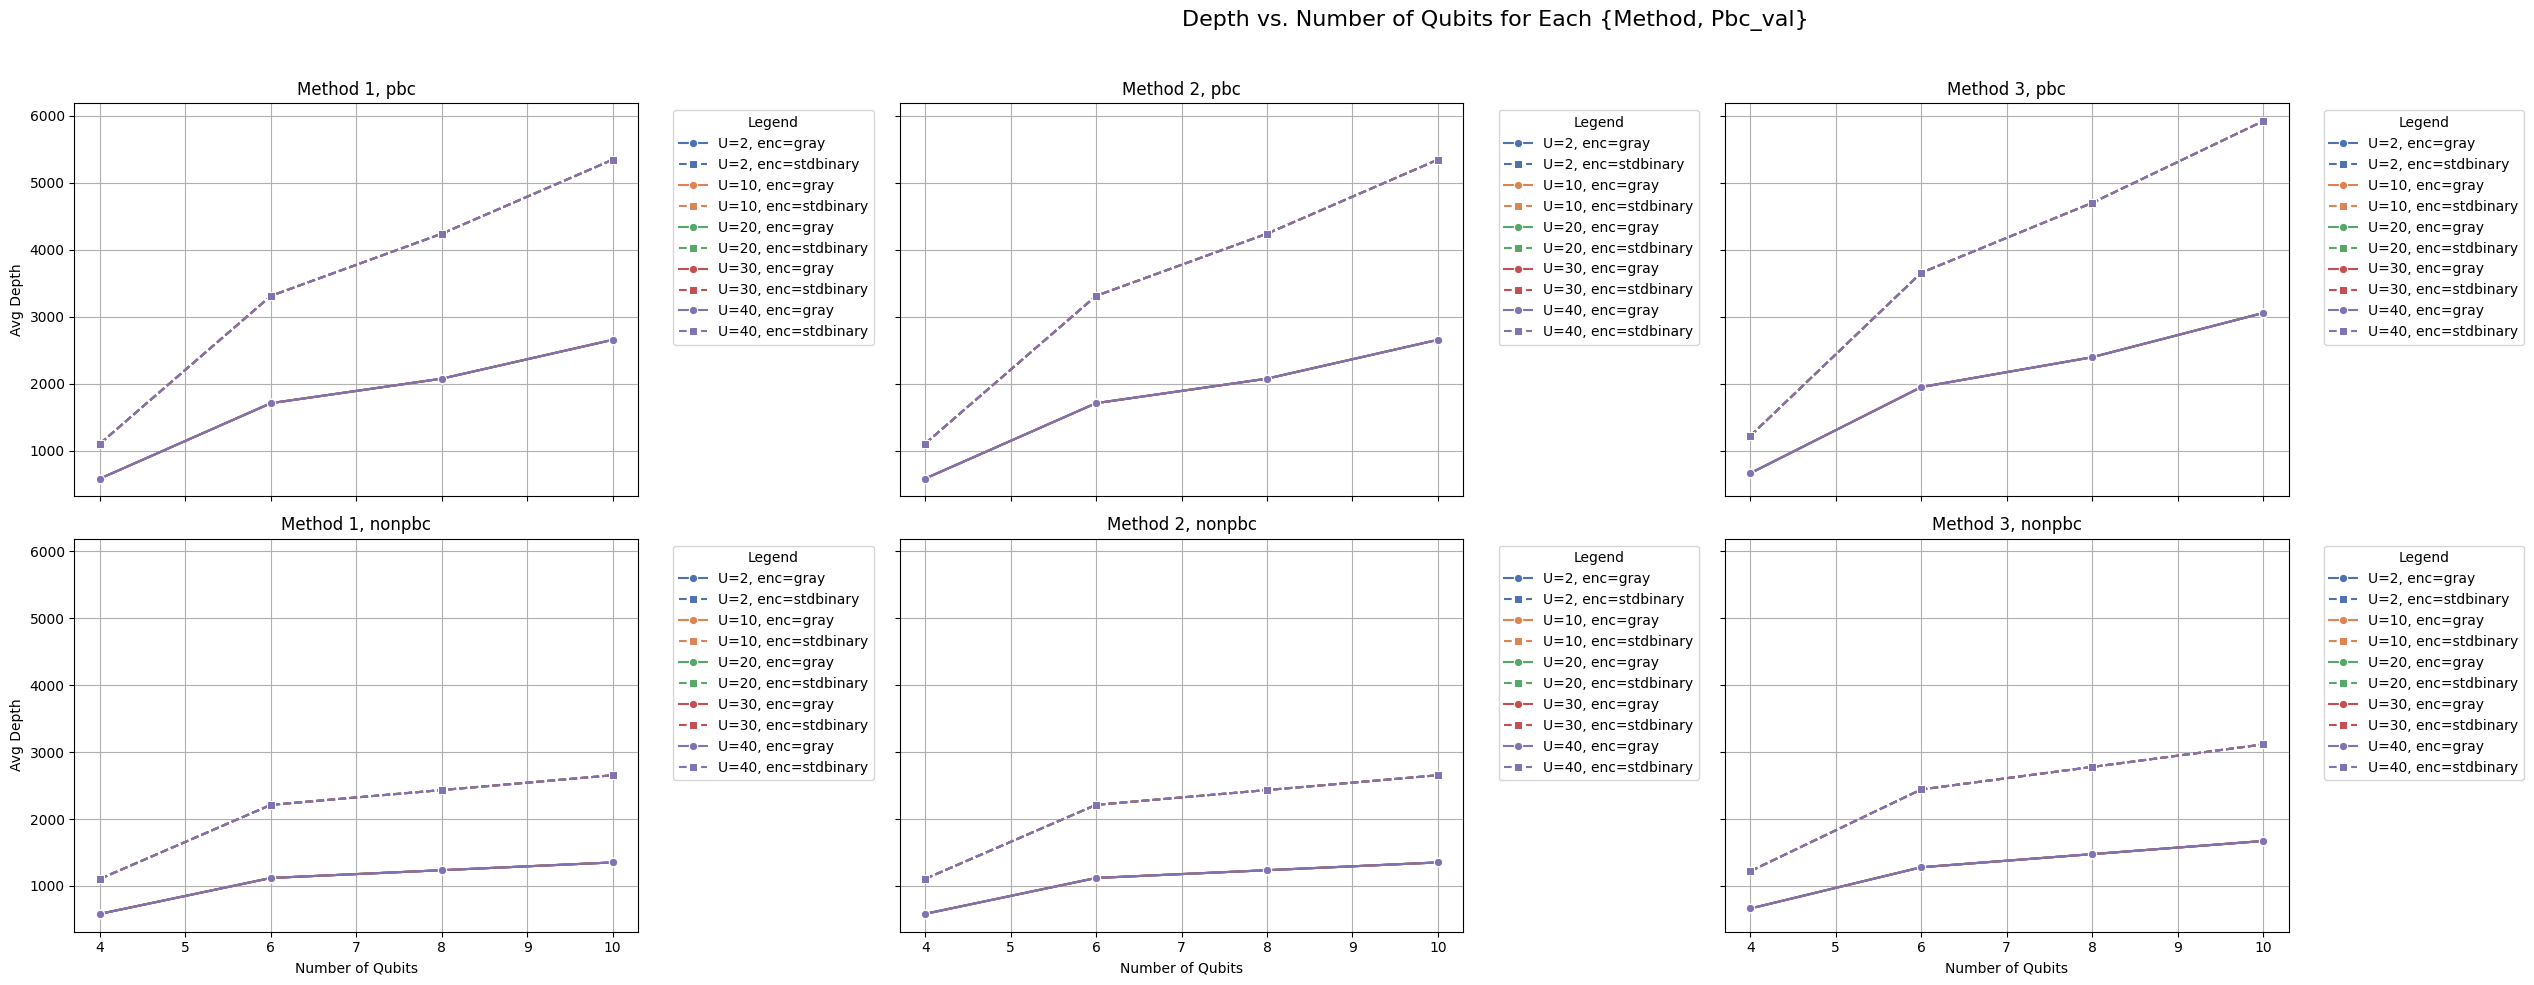

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('__data/collected_bh_data.csv')

# Ensure U and group are treated as integers
df['U'] = df['U'].astype(int)
df['group'] = df['group'].astype(int)

# Create heatmaps for each method and pbc_val
methods = sorted(df['method'].unique())  # Ensure methods are ordered
pbc_vals = df['pbc_val'].unique()
unique_us = sorted(df['U'].unique())
unique_encs = sorted(df['enc'].unique())
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H']  # Different shapes for different encodings
line_styles = ['-', '--', '-.', ':']  # Different line styles for different encodings

# Ensure there are enough markers and line styles
if len(unique_encs) > len(markers):
    markers = markers * (len(unique_encs) // len(markers) + 1)
if len(unique_encs) > len(line_styles):
    line_styles = line_styles * (len(unique_encs) // len(line_styles) + 1)

# Set up the figure for subplots
fig, axs = plt.subplots(len(pbc_vals), len(methods), figsize=(10 * len(methods), 5 * len(pbc_vals)), sharey=True, sharex=True)
fig.suptitle('Depth vs. Number of Qubits for Each {Method, Pbc_val}', fontsize=16)

for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        subset = df[(df['method'] == method) & (df['pbc_val'] == pbc_val)]
        
        ax = axs[i, j]
        
        for U, color in zip(unique_us, sns.color_palette("deep", len(unique_us))):
            for k, (enc, marker, line_style) in enumerate(zip(unique_encs, markers, line_styles)):
                enc_subset = subset[(subset['U'] == U) & (subset['enc'] == enc)]
                if not enc_subset.empty:
                    sns.lineplot(
                        x='group', y='avg_depth', data=enc_subset, 
                        marker=marker, linestyle=line_style, color=color, ax=ax, label=f'U={U}, enc={enc}'
                    )

        ax.set_title(f'Method {method}, {pbc_val}')
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Depth')
        ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()


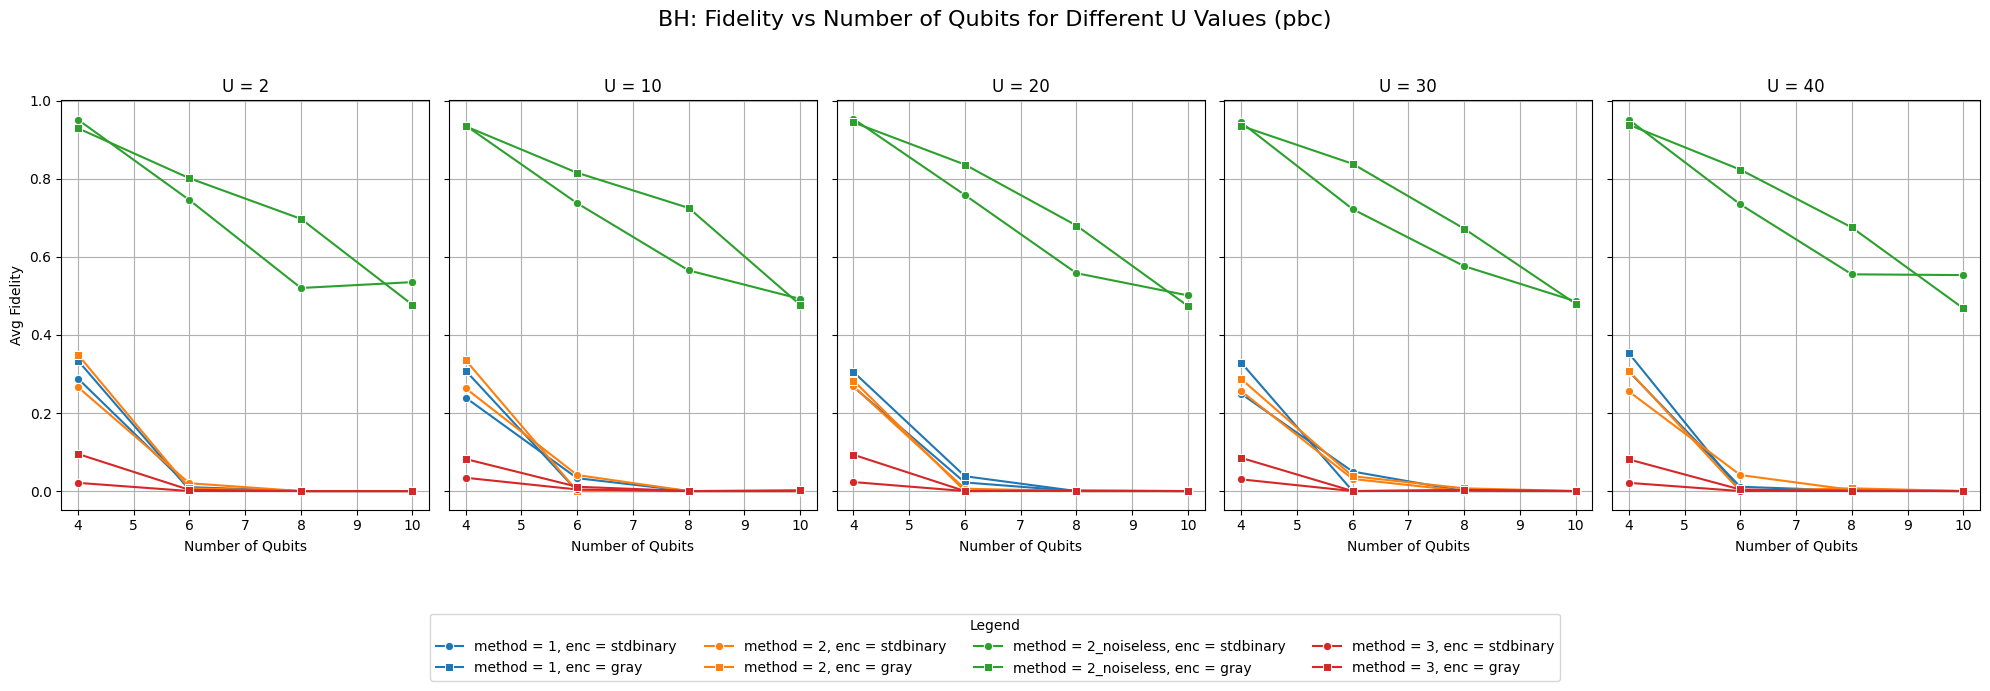

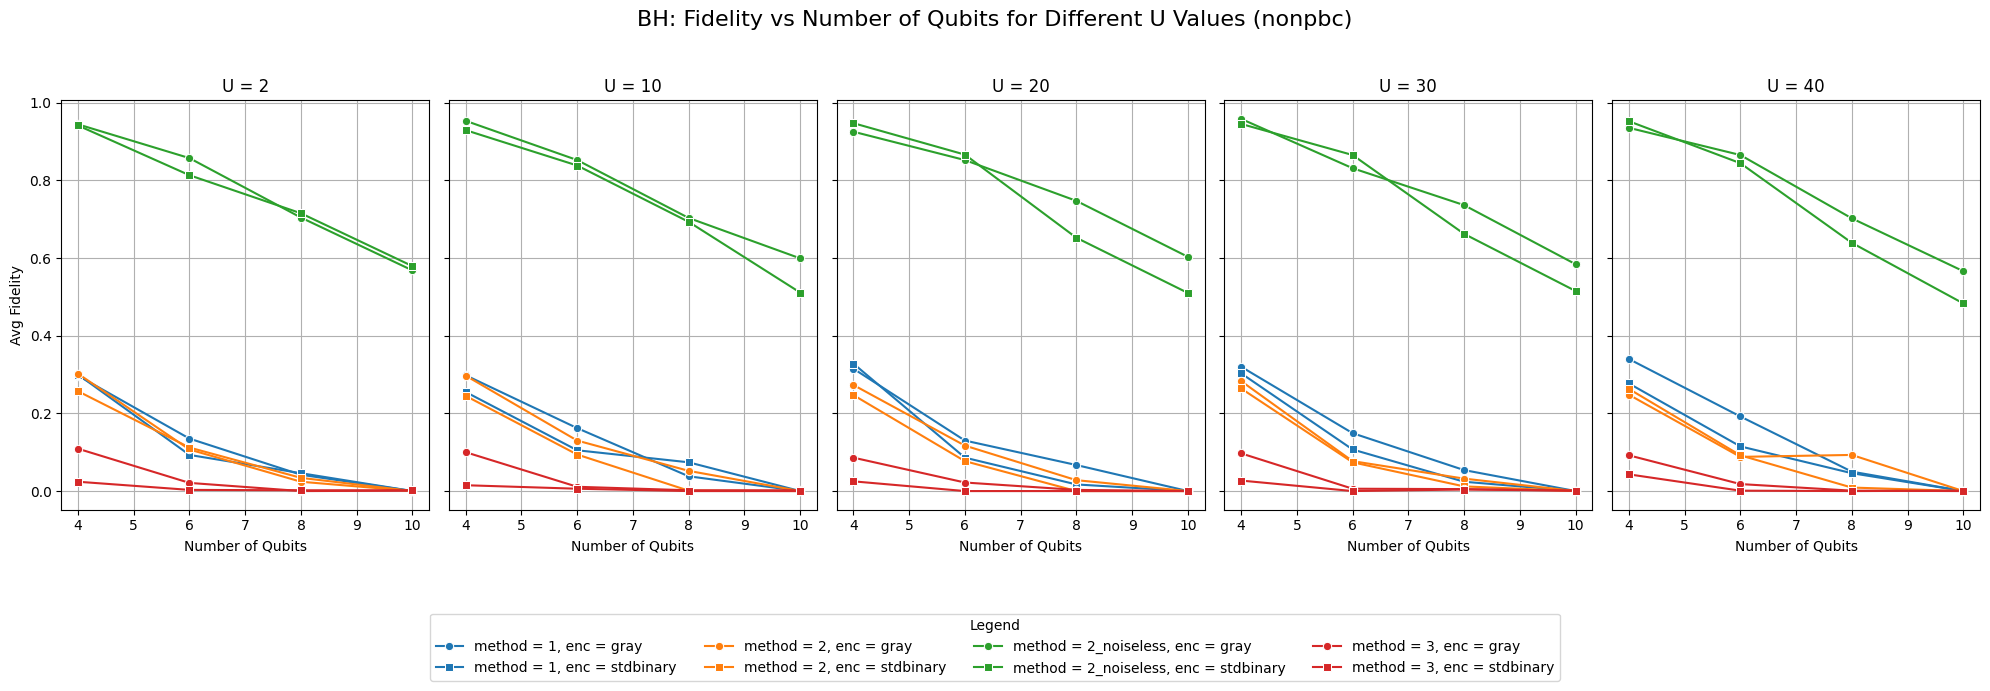

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_bh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Define methods, colors, and markers
methods = ['1', '2', '2_noiseless', '3']
colors = sns.color_palette("tab10", len(methods))
markers = ['o', 's', 'D']

# Ensure 'group' and 'U' are treated as integers
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Unique U values
U_values = sorted(df_combined['U'].unique())
pbc_values = ['pbc', 'nonpbc']

# Function to create plots for a given pbc_val
def plot_for_pbc(pbc_val):
    subset_df = df_combined[df_combined['pbc_val'] == pbc_val]

    # Set up the figure for subplots
    fig, axs = plt.subplots(1, len(U_values), figsize=(20, 6), sharey=True)
    fig.suptitle(f'BH: Fidelity vs Number of Qubits for Different U Values ({pbc_val})', fontsize=16)

    for ax, U in zip(axs.flat, U_values):
        for method, color in zip(methods, colors):
            for enc, marker in zip(subset_df['enc'].unique(), markers):
                subset = subset_df[(subset_df['U'] == U) & (subset_df['method'] == method) & (subset_df['enc'] == enc)]
                if not subset.empty:
                    label = f"method = {method}, enc = {enc}"
                    sns.lineplot(data=subset, x='group', y='avg_fidelity', ax=ax, label=label, color=color, marker=marker, errorbar=None)
        
        ax.set_title(f"U = {U}")
        ax.set_xlabel('Number of Qubits')
        ax.set_ylabel('Avg Fidelity')
        ax.grid(True)
        ax.legend_.remove()  # Remove the legend from the subplot

    # Create a single legend for all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), title='Legend', ncol=4)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Plot for PBC and non-PBC values
for pbc_val in pbc_values:
    plot_for_pbc(pbc_val)


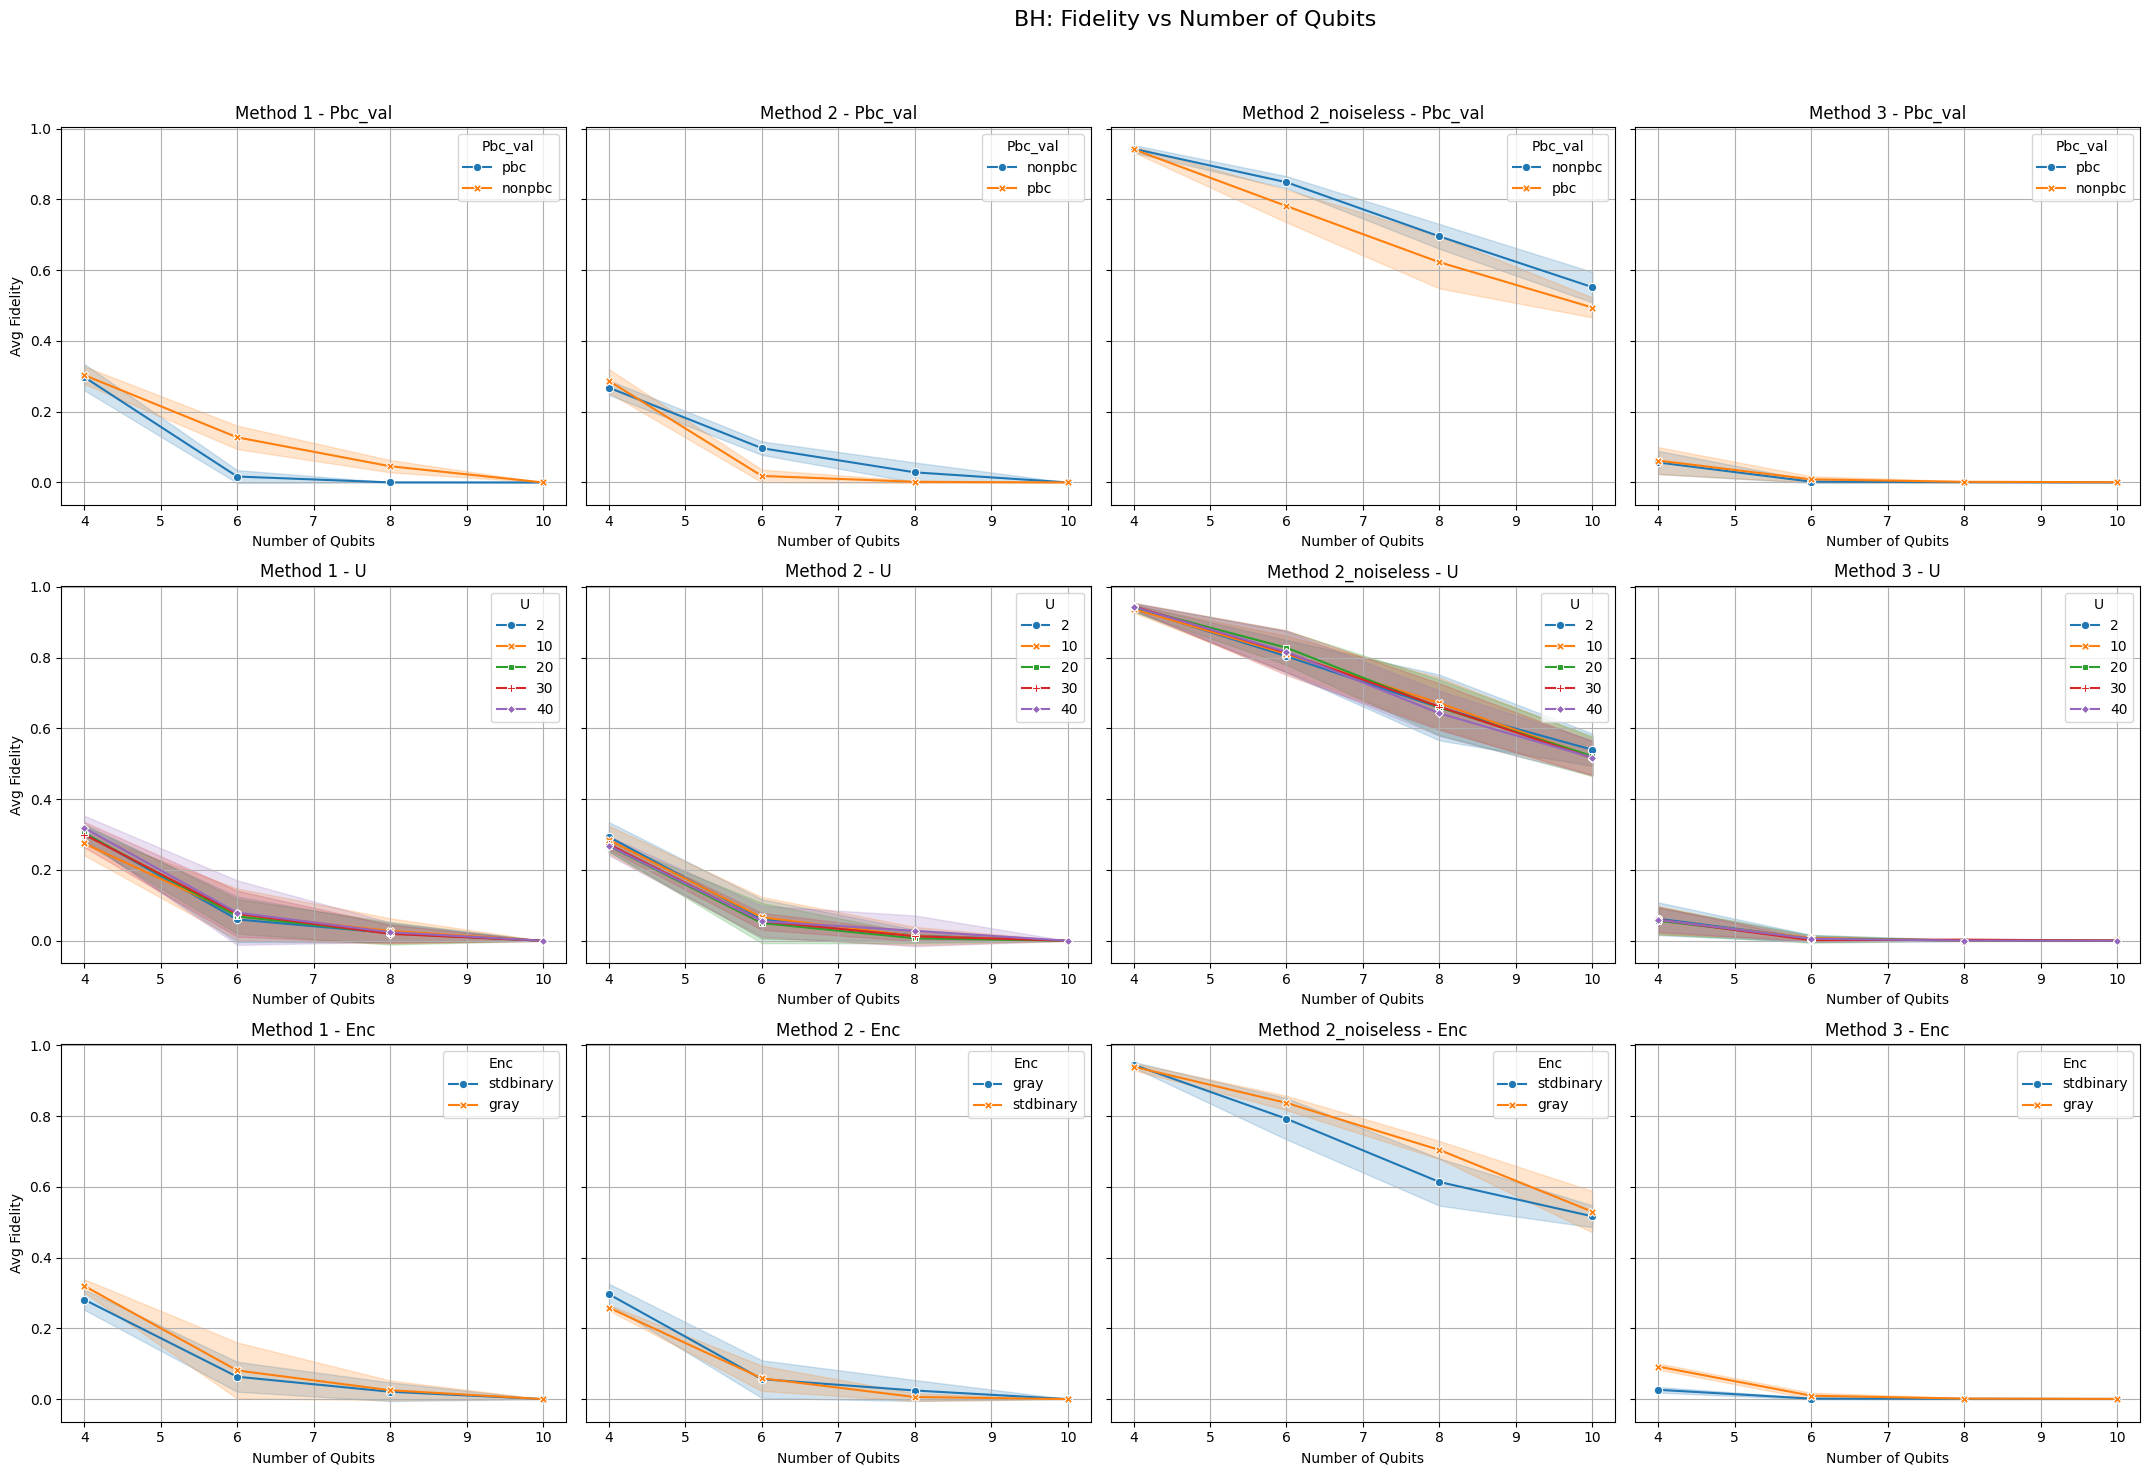

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_bh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers where applicable
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Define methods and rows
methods = ['1', '2', '2_noiseless', '3']
rows = ['pbc_val', 'U', 'enc']
cols = methods

# Set up the figure for subplots
fig, axs = plt.subplots(3, 4, figsize=(24, 15), sharey=True)
fig.suptitle('BH: Fidelity vs Number of Qubits', fontsize=16)

# Plotting function
def plot_subplot(ax, df, row, col, hue):
    palette = sns.color_palette("tab10", len(df[hue].unique()))
    sns.lineplot(
        data=df[df['method'] == col], x='group', y='avg_fidelity', hue=hue, 
        style=hue, ax=ax, markers=True, dashes=False, palette=palette, errorbar='sd'
    )
    ax.set_title(f"Method {col} - {row.capitalize()}")
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Avg Fidelity')
    ax.grid(True)
    ax.legend(title=hue.capitalize(), loc='upper right')

# Generate plots
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        plot_subplot(axs[i, j], df_combined, row, col, row)

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


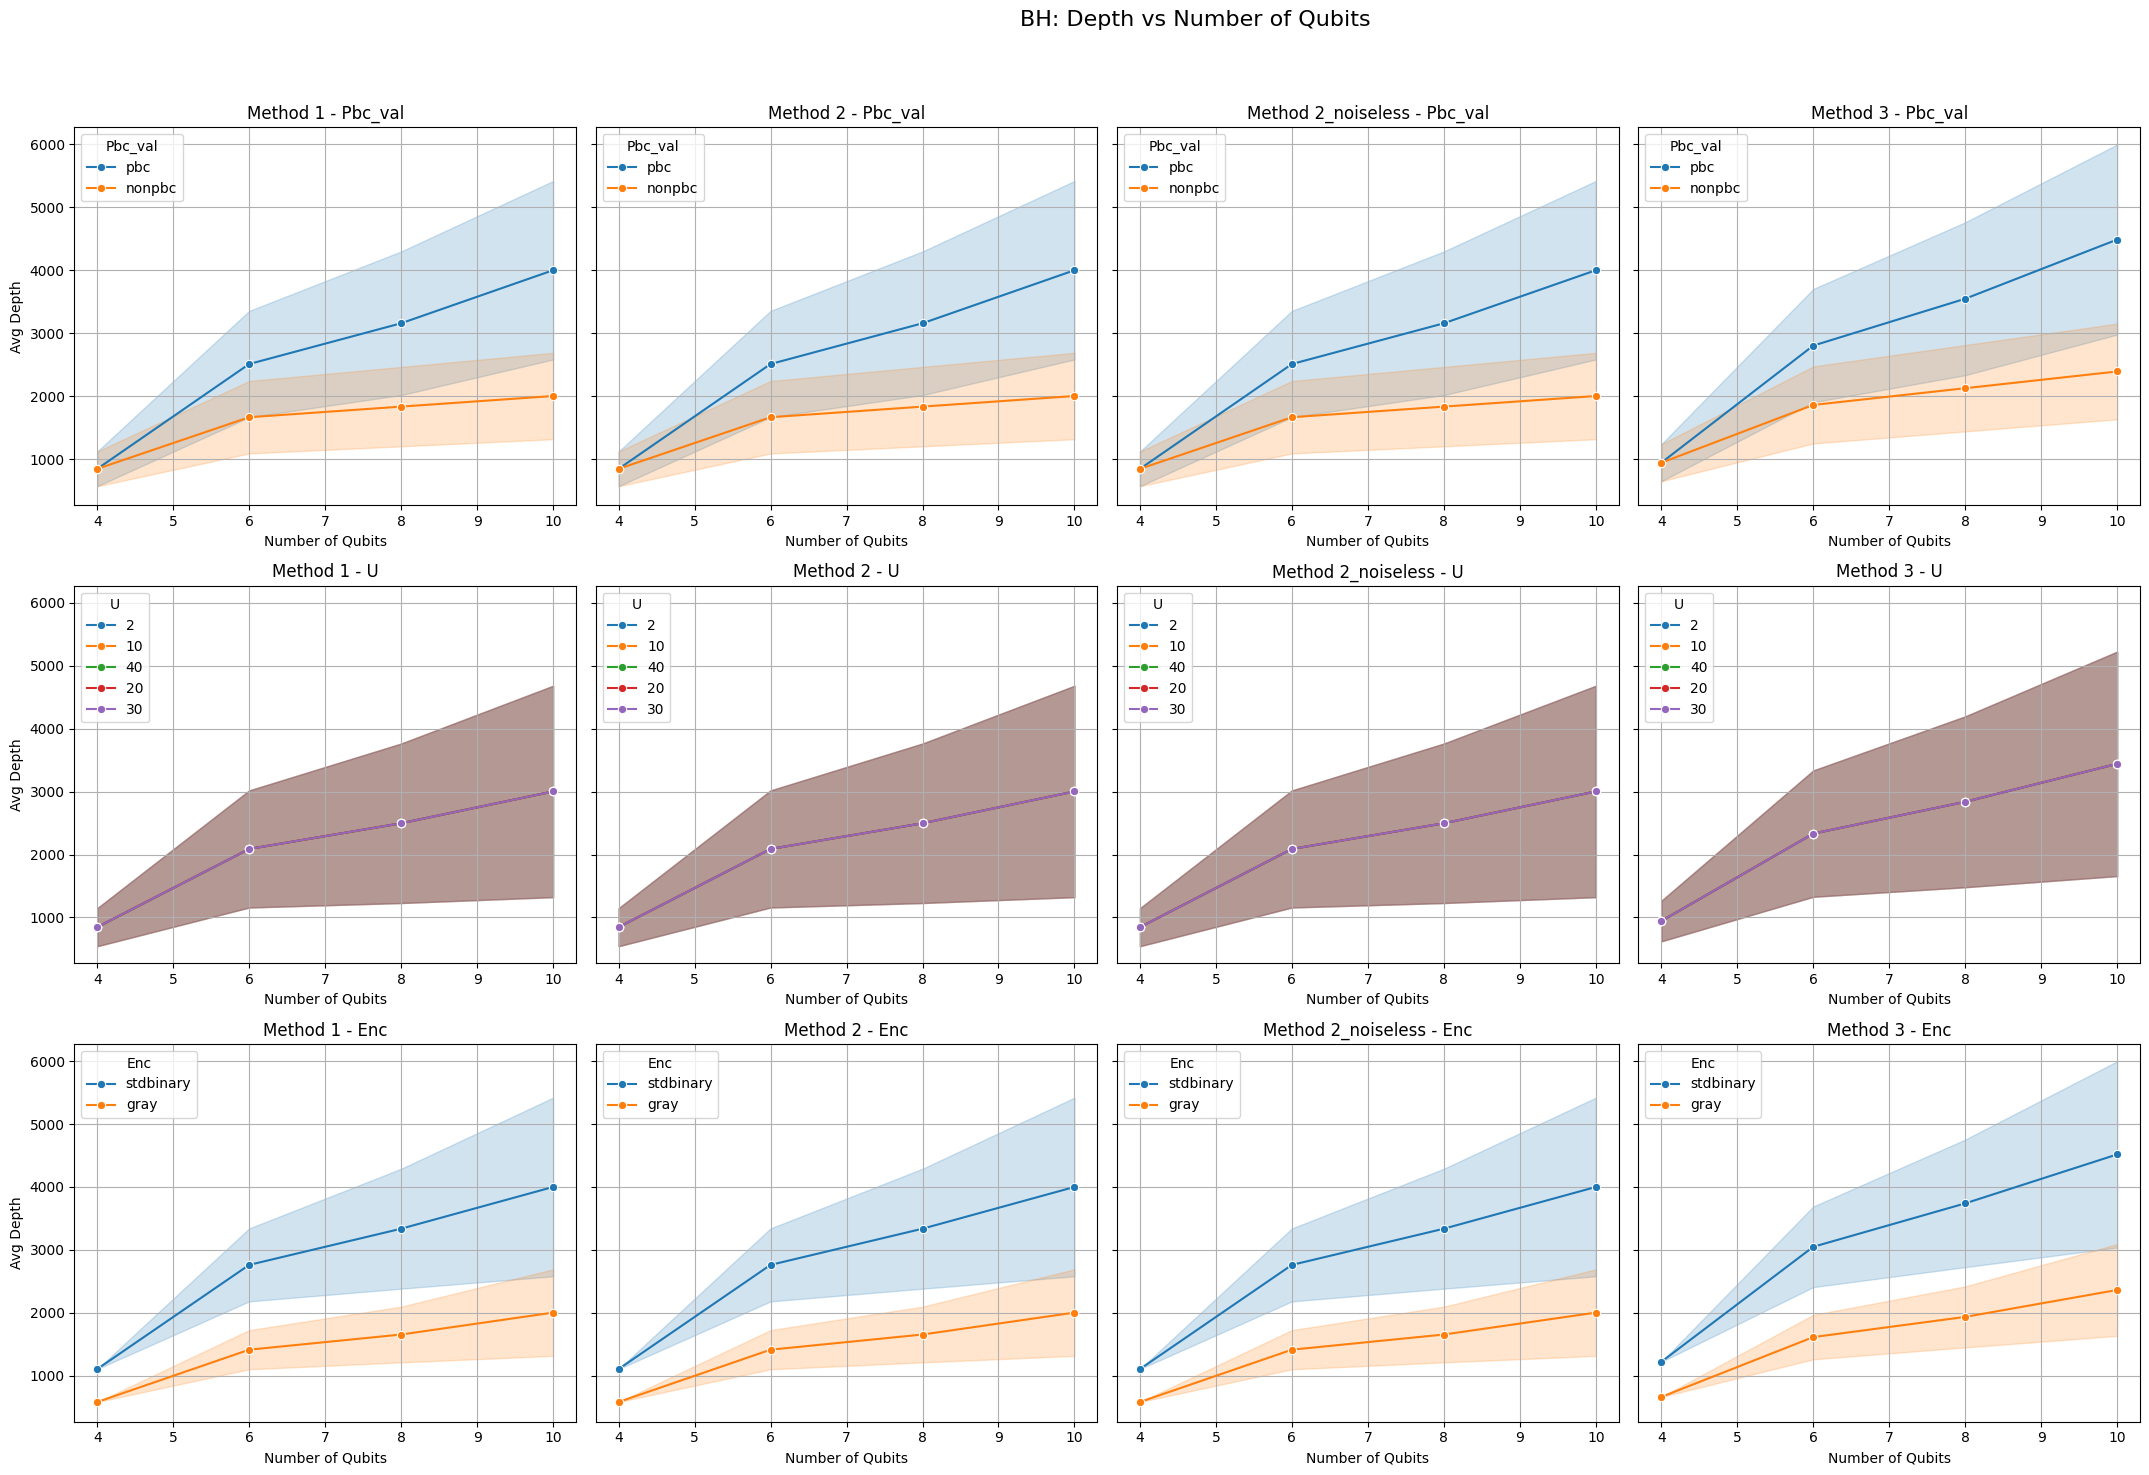

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_bh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
df_fh_noiseless['method'] = '2_noiseless'
df_fh['method'] = df_fh['method'].astype(str)
df_combined = pd.concat([df_fh, df_fh_noiseless])

# Ensure 'group', 'U', and 'method' are treated as integers where applicable
df_combined['group'] = df_combined['group'].astype(int)
df_combined['U'] = df_combined['U'].astype(int)

# Define methods and rows
methods = ['1', '2', '2_noiseless', '3']
rows = ['pbc_val', 'U', 'enc']
cols = methods

# Set up the figure for subplots
fig, axs = plt.subplots(3, 4, figsize=(24, 15), sharey=True)
fig.suptitle('BH: Depth vs Number of Qubits', fontsize=16)

# Plotting function
def plot_subplot(ax, df, row, col, hue):
    unique_values = df[hue].unique()
    palette = sns.color_palette("tab10", len(unique_values))
    
    for color, hue_value in zip(palette, unique_values):
        subset = df[(df['method'] == col) & (df[row] == hue_value)]
        if not subset.empty:
            sns.lineplot(
                data=subset, x='group', y='avg_depth', label=hue_value,
                ax=ax, color=color, marker='o', errorbar='sd'
            )
            ax.set_title(f"Method {col} - {row.capitalize()}")
            ax.set_xlabel('Number of Qubits')
            ax.set_ylabel('Avg Depth')
            ax.grid(True)
            ax.legend(title=hue.capitalize(), loc='upper left')

# Generate plots
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        plot_subplot(axs[i, j], df_combined, row, col, row)

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


# Compare FH vs BH

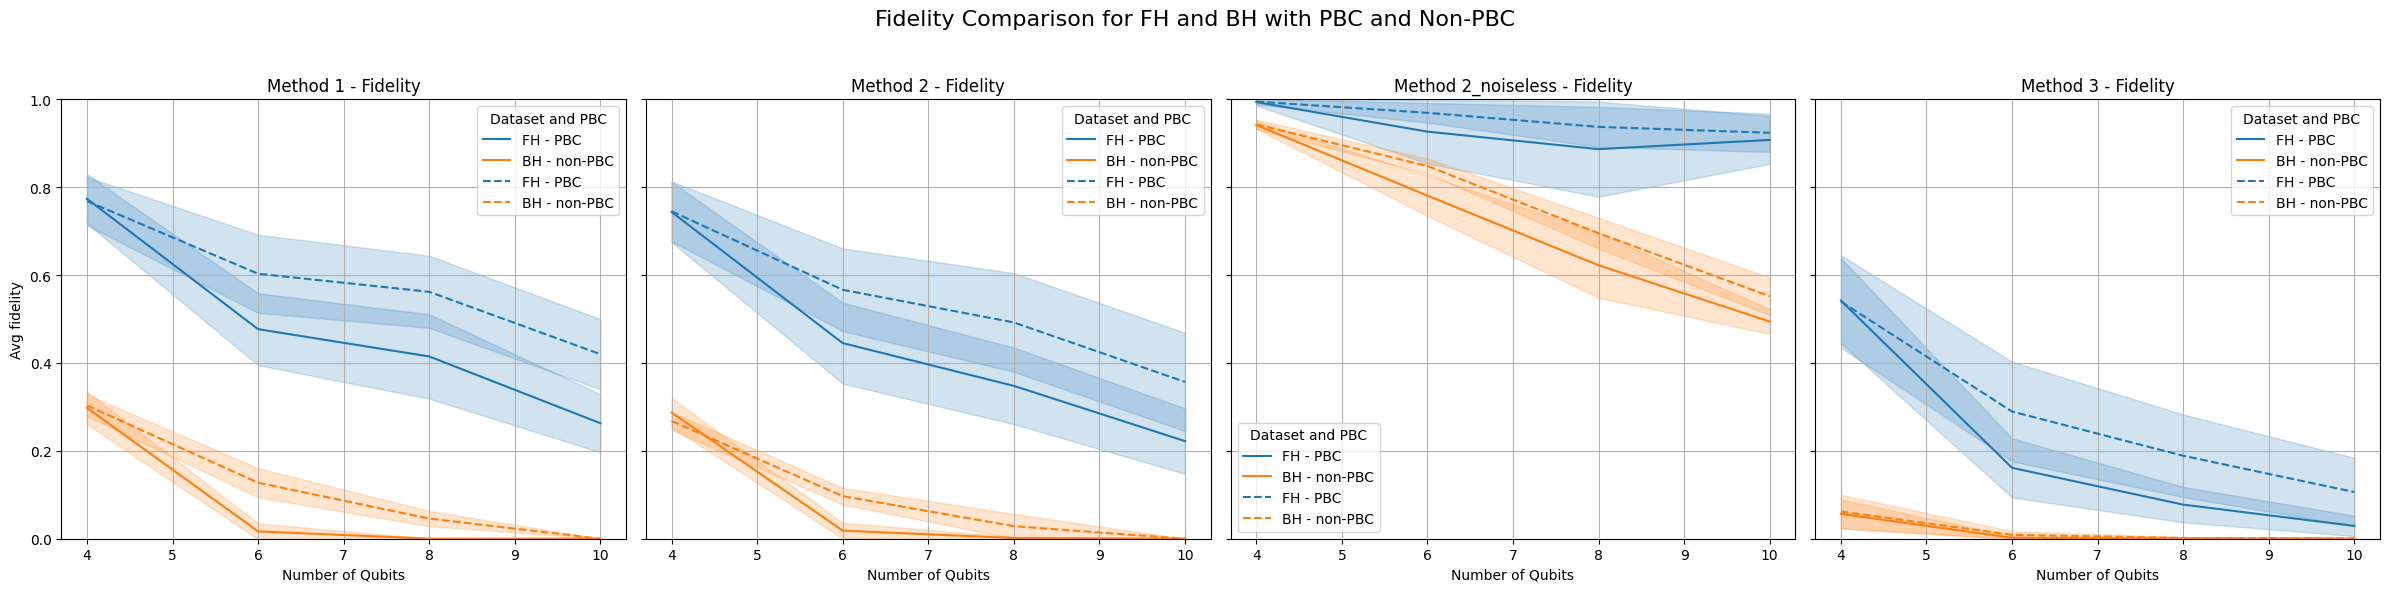

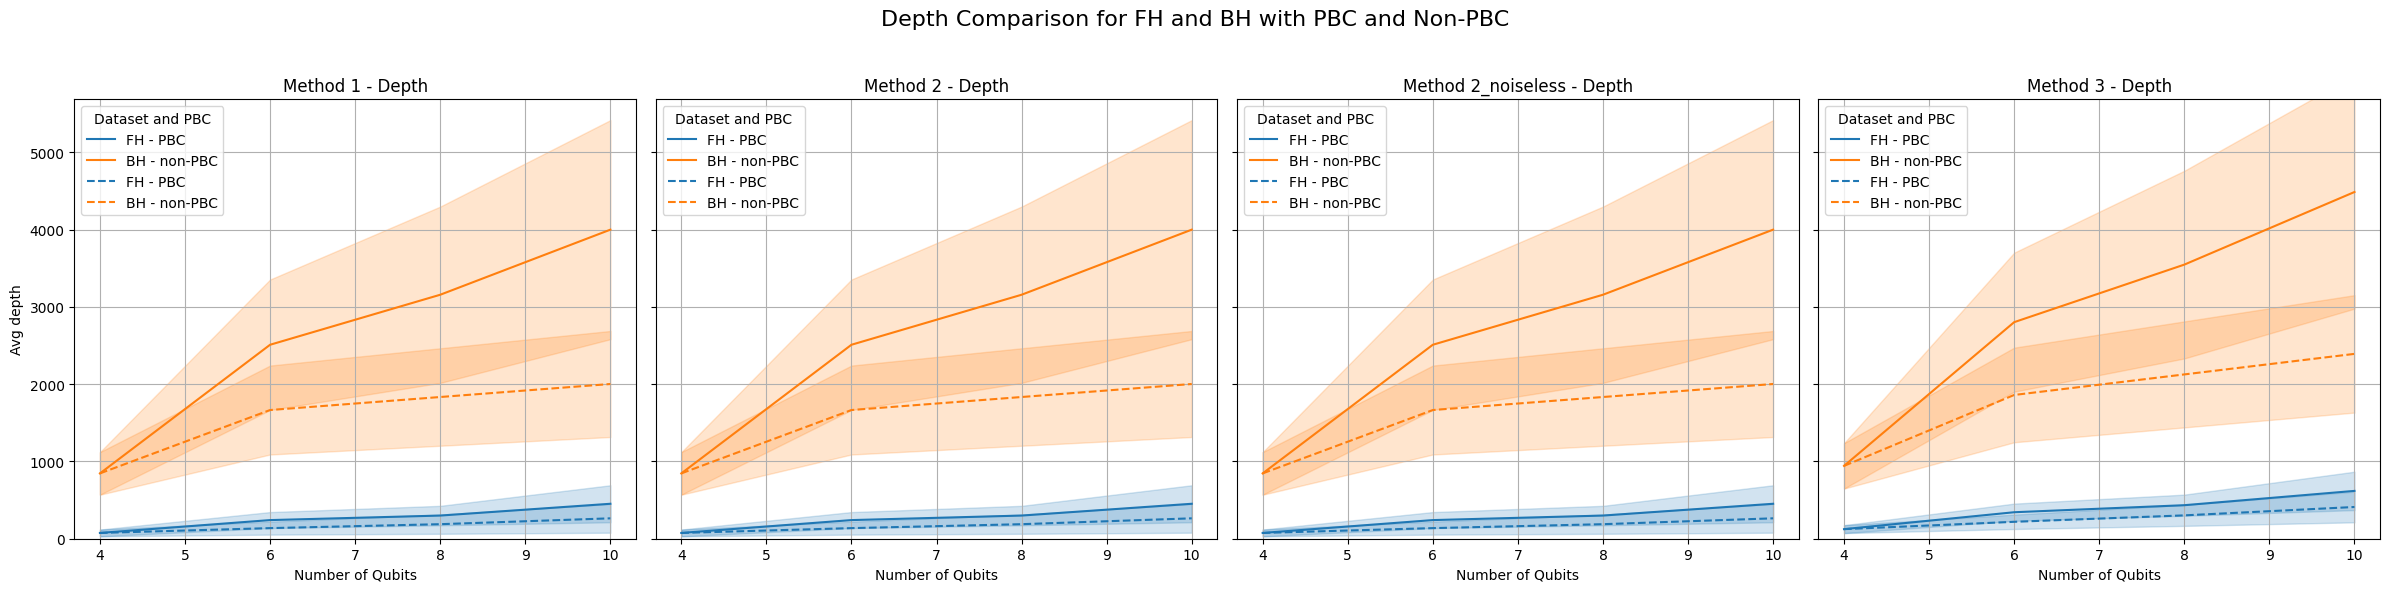

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')
df_bh = pd.read_csv('__data/collected_bh_data.csv')
df_bh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
def combine_noisy_noiseless(df, df_noiseless):
    df_noiseless['method'] = '2_noiseless'
    df['method'] = df['method'].astype(str)
    return pd.concat([df, df_noiseless])

df_fh_combined = combine_noisy_noiseless(df_fh, df_fh_noiseless)
df_bh_combined = combine_noisy_noiseless(df_bh, df_bh_noiseless)

# Ensure 'group' and 'method' are treated as integers where applicable
def preprocess(df):
    df['group'] = df['group'].astype(int)
    if 'U' in df.columns:
        df['U'] = df['U'].astype(int)
    df['method'] = df['method'].astype(str)
    return df

df_fh_combined = preprocess(df_fh_combined)
df_bh_combined = preprocess(df_bh_combined)

# Combine FH and BH data into one DataFrame
df_combined = pd.concat([
    df_fh_combined.assign(dataset='FH'),
    df_bh_combined.assign(dataset='BH')
])

# Define methods
methods = ['1', '2', '2_noiseless', '3']

# Set up the figure for subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
fig.suptitle('Fidelity Comparison for FH and BH with PBC and Non-PBC', fontsize=16)

# Plotting function
def plot_subplot(ax, df, method, y_col, title):
    sns.lineplot(
        data=df[(df['method'] == method) & (df['pbc_val'] == 'pbc')], 
        x='group', y=y_col, hue='dataset', estimator='mean', errorbar='sd', 
        palette='tab10', linestyle='-', ax=ax
    ).set_label('_nolegend_')
    sns.lineplot(
        data=df[(df['method'] == method) & (df['pbc_val'] == 'nonpbc')], 
        x='group', y=y_col, hue='dataset', estimator='mean', errorbar='sd', 
        palette='tab10', linestyle='--', ax=ax
    ).set_label('_nolegend_')
    ax.set_title(title)
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel(y_col.replace('_', ' ').capitalize())
    ax.set_ylim(0, 1 if y_col == 'avg_fidelity' else None)  # Limit fidelity axis to 1
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f"{label} - PBC" if i % 2 == 0 else f"{label} - non-PBC" for i, label in enumerate(labels)]
    ax.legend(handles, new_labels, title='Dataset and PBC',fontsize=10, ncol=1)

# Generate fidelity plots
for j, method in enumerate(methods):
    plot_subplot(axs[j], df_combined, method, 'avg_fidelity', f'Method {method} - Fidelity')

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Set up the figure for subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
fig.suptitle('Depth Comparison for FH and BH with PBC and Non-PBC', fontsize=16)

# Generate depth plots
for j, method in enumerate(methods):
    plot_subplot(axs[j], df_combined, method, 'avg_depth', f'Method {method} - Depth')

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Compare all PBC vs Non PBC

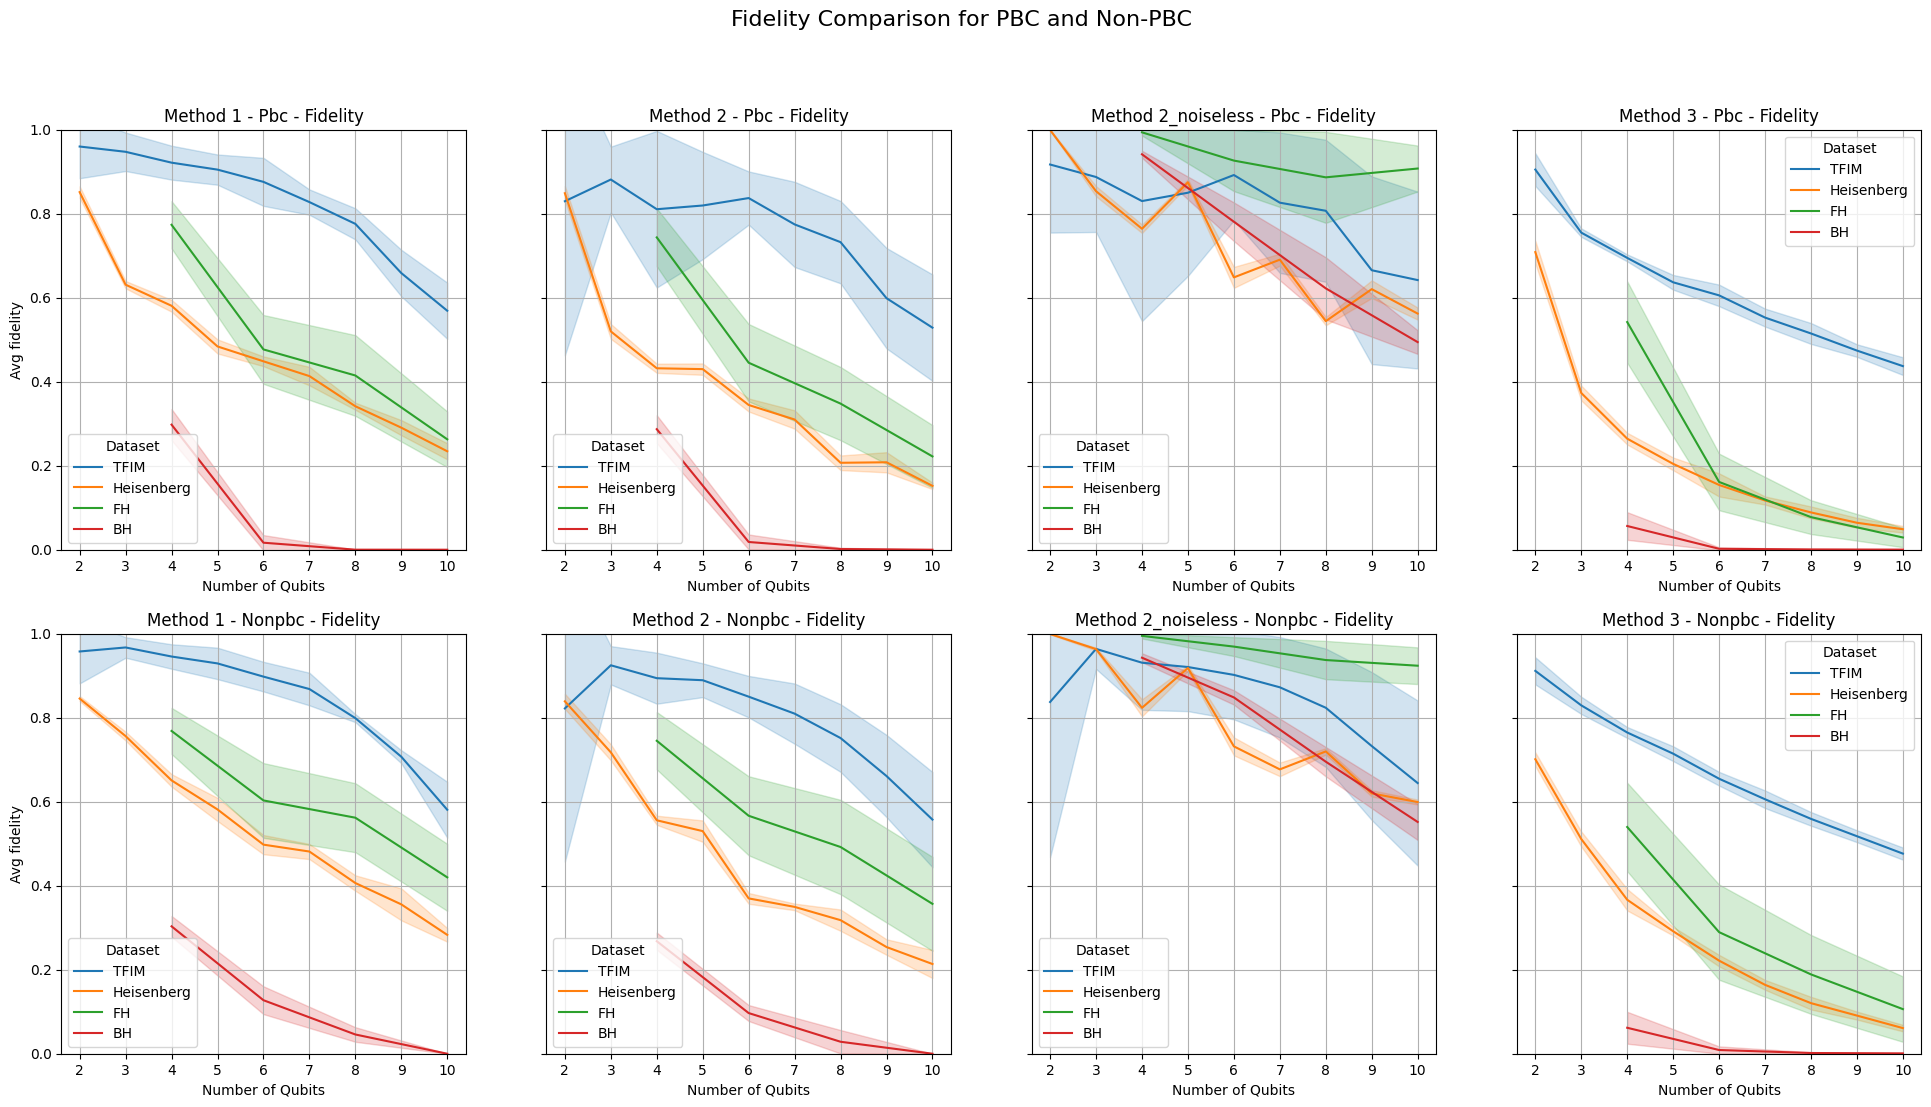

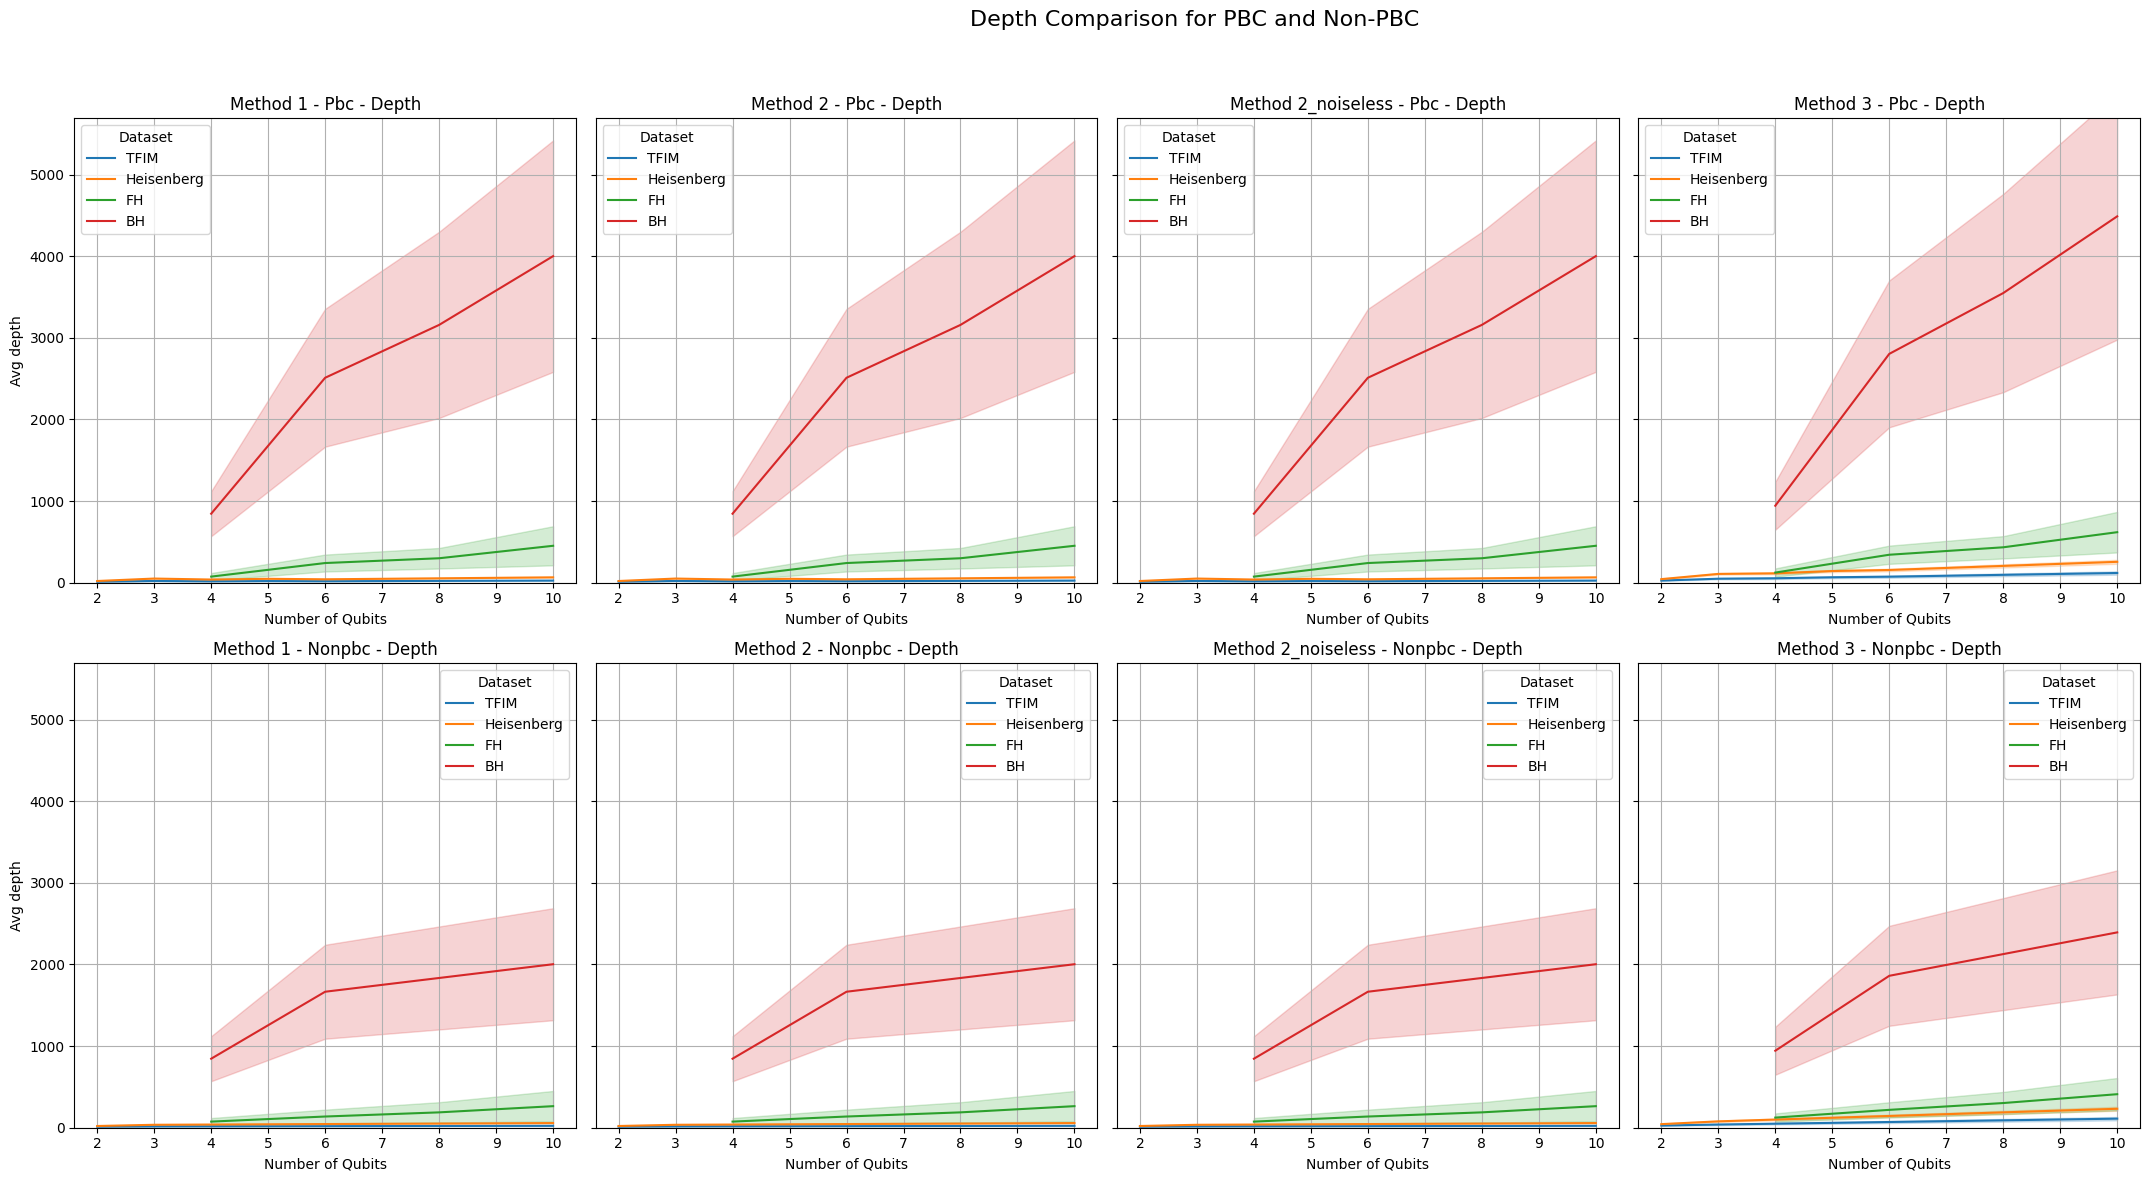

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV files
df_tfim = pd.read_csv('__data/collected_data_tfim.csv')
df_tfim_noiseless = pd.read_csv('__data/collected_data_tfim_noiseless.csv')
df_heis = pd.read_csv('__data/collected_data_heis.csv')
df_heis_noiseless = pd.read_csv('__data/collected_data_heis_noiseless.csv')
df_fh = pd.read_csv('__data/collected_fh_data.csv')
df_fh_noiseless = pd.read_csv('__data/collected_fh_data_noiseless.csv')
df_bh = pd.read_csv('__data/collected_bh_data.csv')
df_bh_noiseless = pd.read_csv('__data/collected_bh_data_noiseless.csv')

# Combine noisy and noiseless data for method 2
def combine_noisy_noiseless(df, df_noiseless):
    df_noiseless['method'] = '2_noiseless'
    df['method'] = df['method'].astype(str)
    return pd.concat([df, df_noiseless])

df_tfim_combined = combine_noisy_noiseless(df_tfim, df_tfim_noiseless)
df_heis_combined = combine_noisy_noiseless(df_heis, df_heis_noiseless)
df_fh_combined = combine_noisy_noiseless(df_fh, df_fh_noiseless)
df_bh_combined = combine_noisy_noiseless(df_bh, df_bh_noiseless)

# Ensure 'group' and 'method' are treated as integers where applicable
def preprocess(df):
    df['group'] = df['group'].astype(int)
    if 'U' in df.columns:
        df['U'] = df['U'].astype(int)
    df['method'] = df['method'].astype(str)
    return df

df_tfim_combined = preprocess(df_tfim_combined)
df_heis_combined = preprocess(df_heis_combined)
df_fh_combined = preprocess(df_fh_combined)
df_bh_combined = preprocess(df_bh_combined)

# Combine all data into one DataFrame
df_combined = pd.concat([
    df_tfim_combined.assign(dataset='TFIM'),
    df_heis_combined.assign(dataset='Heisenberg'),
    df_fh_combined.assign(dataset='FH'),
    df_bh_combined.assign(dataset='BH')
])

# Define methods and pbc values
methods = ['1', '2', '2_noiseless', '3']
pbc_vals = ['pbc', 'nonpbc']

# Set up the figure for subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), sharey=True)
fig.suptitle('Fidelity Comparison for PBC and Non-PBC', fontsize=16)

# Plotting function
def plot_subplot(ax, df, pbc_val, method, y_col, title):
    sns.lineplot(
        data=df[(df['pbc_val'] == pbc_val) & (df['method'] == method)], 
        x='group', y=y_col, hue='dataset', estimator='mean', errorbar='sd', ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel(y_col.replace('_', ' ').capitalize())
    ax.set_ylim(0, 1 if y_col == 'avg_fidelity' else None)  # Limit fidelity axis to 1
    ax.grid(True)
    ax.legend(title='Dataset')

# Generate fidelity plots
for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        plot_subplot(axs[i, j], df_combined, pbc_val, method, 'avg_fidelity', f'Method {method} - {pbc_val.capitalize()} - Fidelity')

# Set up the figure for subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), sharey=True)
fig.suptitle('Depth Comparison for PBC and Non-PBC', fontsize=16)

# Generate depth plots
for j, method in enumerate(methods):
    for i, pbc_val in enumerate(pbc_vals):
        plot_subplot(axs[i, j], df_combined, pbc_val, method, 'avg_depth', f'Method {method} - {pbc_val.capitalize()} - Depth')

# Adjust layout to make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
